# Inicialización

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')  # allow importing from parent directory
from fun_gilles import *
import pickle
import pandas as pd

In [2]:
colors = plt.get_cmap('Set2').colors
plt.rcParams["axes.formatter.use_mathtext"] = True
plt.rcParams["axes.formatter.useoffset"]=False

In [3]:
title_fs = 16
label_fs = 15
tick_fs = 14
legend_fs = 14

In [4]:
def plot_barrido(c_inicial, c_equilibrio, species):
    """
    Plot barrido de diferentes condiciones iniciales: 
    representa arriba la condición inicial aleatoria elegida
    en la parte de abajo el estado estacionario al que se llega
    """

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)
    
    n_conditions = np.arange(len(c_inicial))
    
    # --- Subplot 1: condiciones iniciales ---
    ax1 = axes[0]
    for i in range(len(species)):
        ax1.plot(n_conditions, c_inicial[:, i], label=species[i], color=colors[i], alpha=0.9, marker= "s", linewidth= 2)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_xlabel("Simulation", fontsize= label_fs)
    ax1.set_ylabel("Initial concentration", fontsize= label_fs)
    ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize= legend_fs)
    ax1.tick_params(axis='both', labelsize=tick_fs)
    
    ax2 = axes[1]
    for i in range(len(species)):
        ax2.plot(n_conditions, c_equilibrio[:, i], label=species[i], color=colors[i], alpha=0.9, marker= "s", linewidth= 2)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_xlabel("Simulation", fontsize= label_fs)
    ax2.set_ylabel("Equilibrium concentration", fontsize= label_fs)  
    ax2.tick_params(axis='both', labelsize=tick_fs)  

In [5]:
def plot(abundances, times, V, species, xlim = None):
    """
    Plot de la variación en la concentración y en el volumen
    """

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True) 

    # --- Subplot 1 (Left): Concentration ---
    ax1 = axes[0]
    for i in range(len(species)):
        # Calculate Concentration = Abundance / Volume
        ax1.plot(times, abundances[:, i] / V, label=species[i], color=colors[i], alpha=0.9)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Concentration")
    ax1.set_title("Concentration Evolution")
    ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Species")

    # --- Subplot 2 (Middle): Volume ---
    ax2 = axes[1]
    ax2.plot(times, V, color='gray')
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Volume")
    # ax2.set_yscale("log")
    ax2.set_title("Volume Evolution")
    
    if xlim != None:
        ax1.set_xlim((0,xlim))
        ax2.set_xlim((0,xlim))
   
    # Adjust layout to prevent labels/titles from overlapping
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

In [6]:
f = '../examples/reactions_autocat.txt'
reactions = read_file(f)
species = obtain_species(reactions)

In [7]:
def load_streamed_pickle(filename):
    data = {}
    try:
        with open(filename, "rb") as file:
            while True:
                try:
                    # Load one object (which is a dict of {k_i: (abundances, times, volumes)})
                    chunk = pickle.load(file)
                    # Merge the loaded chunk into the main dictionary
                    data.update(chunk)
                except EOFError:
                    # Reached the end of the file
                    break
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
    
    print(f"Successfully loaded {len(data)} simulation results.")
    return data

In [8]:
def identify_reaction_history(abundance_matrix, c_matrix):
    """
    abundance_matrix: (Steps x Species) matrix of counts
    c_matrix: (Reactions x Species) stoichiometry matrix
    """
    # 1. Calculate the change in molecules between each time step
    # diffs will have shape (Steps-1, Species)
    # eliminamos food species: no cambian según la matriz c
    diffs = np.diff(abundance_matrix, axis=0)[:, 4:]
    c_matrix = c_matrix[:, 4:]
    reaction_history = []
    
    # 2. Match each row of diffs to a row in c_matrix
    for delta in diffs:
        # Check which row in C is equal to the delta
        # We use np.all(..., axis=1) to check all species at once
        matches = np.where((c_matrix == delta).all(axis=1))[0]
        
        if len(matches) > 0:
            # Append the index of the matching reaction
            reaction_history.append(matches[0])
        else:
            # This handles cases where no change occurred (if your code allows that)
            reaction_history.append(None) 
            
    return np.array(reaction_history)

def plot_reaction_timeline(times, reaction_labels, a):
    reaction_history=identify_reaction_history(a, c_matrix(read_file(f),species, get_header(f)))
    
    plt.figure(figsize=(12, 4))
    
    # Plotting the events
    # Ensure reaction_history is filtered for None values if any remain
    plt.scatter(times[1:], reaction_history, marker='|', s=100, color='firebrick')
    
    # Reverse the Y-axis so 0 is at the top
    plt.gca().invert_yaxis()
    
    # Formatting
    plt.yticks(range(len(reaction_labels)), reaction_labels)
    plt.tick_params(axis='both', labelsize=tick_fs)
    plt.xlabel("Time", fontsize=label_fs)
    plt.ylabel("Reaction", fontsize=label_fs)
    plt.title("Reaction Event Timeline", fontsize=title_fs)
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## ajuste a log (funciones)

In [9]:
from numpy.polynomial.polynomial import polyfit

def get_alpha(volumes, times, verbose=True):
    # 1. Transform the data
    log_v = np.log(volumes)
    
    # 2. Perform linear regression: log(V) = log(A) + m * t
    coefficients = polyfit(times, log_v, 1)
    
    # Extract the intercept (log(A)) and slope (m)
    log_A_fit = coefficients[0]
    m_fit = coefficients[1] 
    
    # 3. Calculate the scaling constant A
    A_fit = np.exp(log_A_fit)
    
    
    # --- R-SQUARED CALCULATION ---
    
    # a) Calculate the predicted log(V) values
    # log(V)_predicted = log(A)_fit + m_fit * t
    log_v_predicted = log_A_fit + m_fit * times
    
    # b) Calculate the Mean of the actual log(V) data
    log_v_mean = np.mean(log_v)
    
    # c) Calculate Sum of Squares of Residuals (SS_res)
    # The sum of the squared differences between actual y and predicted y
    SS_res = np.sum((log_v - log_v_predicted)**2)
    
    # d) Calculate Total Sum of Squares (SS_tot)
    # The sum of the squared differences between actual y and mean y
    SS_tot = np.sum((log_v - log_v_mean)**2)
    
    # e) Calculate R-squared
    R_squared = 1 - (SS_res / SS_tot)
    
    # -----------------------------
    if verbose:
        print(f"Regression completed. Fitted Scaling Constant A: {A_fit:.3f}")
        print(f"Fitted exponential rate m (alpha): {m_fit:.3f}")
        print(f"Coefficient of Determination (R^2): {R_squared:.4f}")
     
    def function_v(t_new):
               
        predicted_V = A_fit * np.exp(m_fit * t_new) 
        # V(t) = A * e^(m * t)
        return predicted_V

    return function_v


In [10]:
def plot_ajuste(abundances, times, volumes, species):


        # --- Create the figure and a 1-row, 3-column subplot grid ---
        # Using a wide figsize for a horizontal layout.
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True) 
        # Note: sharex=True is removed because we need the x-axis ticks on all three plots, 
        # although they are the same (time).

        # --- Subplot 1: Concentration ---
        ax1 = axes[0]
        for i in range(len(species)):
        # Calculate Concentration = Abundance / Volume
                ax1.plot(times, abundances[:, i] / volumes, label=species[i], color=colors[i], alpha=0.9)
        ax1.grid(True, linestyle='--', alpha=0.3)
        ax1.set_xlabel("Time", fontsize= label_fs)
        ax1.set_ylabel("Concentration", fontsize= label_fs)
        ax1.set_title("Concentration Evolution", fontsize= title_fs)
        ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize= legend_fs)
        ax1.tick_params(axis= "both", labelsize= tick_fs)


        # --- Subplot 2: Volume ---
        ax2 = axes[1]
        ax2.plot(times, volumes, color='gray', linewidth= 2)
        ax2.grid(True, linestyle='--', alpha=0.3)
        ax2.set_xlabel("Time", fontsize= label_fs)
        ax2.set_ylabel("Volume", fontsize= label_fs)
        ax2.set_yscale("log")
        ax2.set_title("Volume Evolution and Fit", fontsize= title_fs)
        ax2.tick_params(axis= 'both', labelsize= tick_fs)
        
        # --- Fit ---
        func = get_alpha(volumes[round(len(times)/5):], times[round(len(times)/5):])

        volume_predicted = []

        for t in times[round(len(times)/5):]:
                volume_predicted.append(func(t))

        volume_predicted = np.array(volume_predicted)

        ax2.plot(times[round(len(times)/5):], volume_predicted, 
                label=fr'Fit', color= colors[1], linestyle= '--', linewidth= 2)
        ax2.legend(loc='lower right', fontsize= legend_fs)


        plt.tight_layout()
        plt.show()
        print("Plot generated successfully.")

In [11]:
# def plot_vol(times, volumes):


#         # --- Create the figure and a 1-row, 3-column subplot grid ---
#         # Using a wide figsize for a horizontal layout.
#         plt.figure()

#         # --- Subplot 2 (Middle): Volume ---
#         plt.plot(times, volumes, color='gray', linewidth= 2)
#         plt.grid(True, linestyle='--', alpha=0.3)
#         plt.xlabel("Time", fontsize= label_fs)
#         plt.ylabel("Volume", fontsize= label_fs)
#         plt.yscale("log")
#         plt.title("Volume Evolution and Fit", fontsize= title_fs)
#         plt.tick_params(axis= 'both', labelsize= tick_fs)


#         # --- Final Touches ---
#         # Add a figure-wide title


#         func = get_alpha(volumes[round(len(times)/5):], times[round(len(times)/5):])

#         volume_predicted = []

#         for t in times[round(len(times)/5):]:
#                 volume_predicted.append(func(t))

#         volume_predicted = np.array(volume_predicted)

#         plt.plot(times[round(len(times)/5):], volume_predicted, 
#                 label=fr'Fit', color= colors[1], linestyle= '--', linewidth= 4)
#         plt.legend(loc='lower right', fontsize= legend_fs)


#         plt.tight_layout()
#         plt.show()
#         print("Plot generated successfully.")

# import matplotlib.pyplot as plt
# import numpy as np

def plot_vol(times, volumes):
    # Parameters for styling

    colors = ['gray', 'red']
    
    # 1. Define the range for the fit (skipping the first 1/5th as in your original code)
    start_idx = round(len(times) / 5)
    fit_times = times[start_idx:]
    fit_volumes = volumes[start_idx:]

    # 2. Get the fit and predict volumes
    # Assuming get_alpha returns a function like: lambda t: exp(intercept + alpha * t)
    func = get_alpha(fit_volumes, fit_times)
    volume_predicted = np.array([func(t) for t in fit_times])

    # 3. Calculate Residuals in Log-Space
    # We use log-space because the fit is exponential; this shows the percentage deviation
    residuals = np.log(fit_volumes) - np.log(volume_predicted)

    # 4. Create the Figure with 2 Subplots (Vertical Stack)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, 
                                   gridspec_kw={'height_ratios': [3, 1]})

    # --- Subplot 1: Volume Evolution and Fit ---
    ax1.plot(times, volumes, color=colors[0], linewidth=2, label="Simulated Data")
    ax1.plot(fit_times, volume_predicted, color=colors[1], linestyle='--', 
             linewidth=3, label="Exponential Fit")
    
    ax1.set_yscale("log")
    ax1.set_ylabel("Volume", fontsize=label_fs)
    ax1.set_title("Volume Evolution and Residual Analysis", fontsize=title_fs)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.legend(loc='lower right', fontsize=legend_fs)
    ax1.tick_params(axis='both', labelsize=tick_fs)

    # --- Subplot 2: Residuals ---
    ax2.scatter(fit_times, residuals, color='purple', s=10, alpha=0.5)
    ax2.axhline(0, color='black', linestyle='-', linewidth=1) # Zero-line
    
    ax2.set_xlabel("Time", fontsize=label_fs)
    ax2.set_ylabel("Residuals (Log)", fontsize=label_fs)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.tick_params(axis='both', labelsize=tick_fs)

    plt.tight_layout()
    plt.show()
    print("Plot with residuals generated successfully.")
        
def plot_conc(abundances, times, volumes, species):
        plt.figure()

        # --- Subplot 1 (Left): Concentration ---
        for i in range(len(species)):
        # Calculate Concentration = Abundance / Volume
                plt.plot(times, abundances[:, i] / volumes, label=species[i], color=colors[i], alpha=0.9)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.xlabel("Time", fontsize= label_fs)
        plt.ylabel("Concentration", fontsize= label_fs)
        plt.title("Concentration Evolution", fontsize= title_fs)
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize= legend_fs)
        plt.tick_params(axis= "both", labelsize= tick_fs)


        plt.tight_layout()
        plt.show()
        print("Plot generated successfully.")
        
def plot_ab(abundances, times, species):
        plt.figure()

        # --- Subplot 1 (Left): Concentration ---
        for i in range(len(species)):
        # Calculate Concentration = Abundance / Volume
                plt.plot(times, abundances[:, i], label=species[i], color=colors[i], alpha=0.9)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.xlabel("Time", fontsize= label_fs)
        plt.ylabel("Abundance", fontsize= label_fs)
        plt.title("Abundance Evolution", fontsize= title_fs)
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize= legend_fs)
        plt.tick_params(axis= "both", labelsize= tick_fs)


        plt.tight_layout()
        plt.show()
        print("Plot generated successfully.")

In [12]:
def get_alpha_global(results: dict):
    # Initialize a list of lists/tuples to hold the data temporarily
    data = [] 
    
    for conc, (species, times, volumes) in results.items(): 
        
        times = np.array(times)
        volumes = np.array(volumes)
        
            
        # Use data points from index len(x)/2 onwards for a better fit
        log_v = np.log(volumes[round(len(volumes)/5):])
        t_subset = times[round(len(times)/5):]
        
        # 2. Perform linear regression
        coefficients = polyfit(t_subset, log_v, 1)
        log_A_fit = coefficients[0]
        m_fit = coefficients[1] # alpha
        A_fit = np.exp(log_A_fit)
        
        # --- R-SQUARED CALCULATION (Use the same logic as before, but with subsets) ---
        log_v_predicted = log_A_fit + m_fit * t_subset
        log_v_mean = np.mean(log_v)
        SS_res = np.sum((log_v - log_v_predicted)**2)
        SS_tot = np.sum((log_v - log_v_mean)**2)
        R_squared = 1 - (SS_res / SS_tot)
        
        # Append the calculated metrics to the data list
        data.append({
            'Condition': conc,
            'Alpha': m_fit,
            'Scaling Const. (A)': A_fit,
            'R^2': R_squared
        })
    
    # Convert the list of dictionaries into a DataFrame
    df_fit = pd.DataFrame(data)
    df_fit = df_fit.sort_values(by=['Condition'])
    return df_fit

In [13]:
def get_alpha_single_run(cond:float, result:tuple, values_used = None):
    _, times, volumes = result
        
    times = np.array(times)
    volumes = np.array(volumes)
    
    # Use data points from index len/5 onwards
    if values_used == None:
        start_idx = round(len(volumes) / 5)
        log_v = np.log(volumes[start_idx:])
        t_subset = times[start_idx:]
    
    else:
        values_used = round(len(volumes) * values_used)
        log_v = np.log(volumes[:values_used])
        t_subset = times[:values_used]
    
    # 2. Perform linear regression
    # polyfit(x, y, 1) returns [slope, intercept]
    coefficients = np.polyfit(t_subset, log_v, 1)
    m_fit = coefficients[0]      # This is alpha (slope)
    log_A_fit = coefficients[1]  # This is the intercept
    A_fit = np.exp(log_A_fit)
    
    # --- R-SQUARED CALCULATION ---
    log_v_predicted = log_A_fit + m_fit * t_subset
    log_v_mean = np.mean(log_v)
    SS_res = np.sum((log_v - log_v_predicted)**2)
    SS_tot = np.sum((log_v - log_v_mean)**2)
    R_squared = 1 - (SS_res / SS_tot) if SS_tot != 0 else 0
    
    
    rmse = np.sqrt(SS_res / len(volumes)) if len(volumes) > 0 else 0
    
    # Return a dictionary directly
    return {
        'Condition': cond,
        'Alpha': m_fit,
        'Scaling Const. (A)': A_fit,
        'R^2': R_squared,
        'RMSE': rmse
    }

In [14]:
def plot_all_volumes(results: dict, k_i, xlim= None, ylim= None, lim= None, rep= 0):
    if lim != None:
        filtered_conditions = [c for c in results.keys() if lim[0] < float(c) < lim[1]] 

    else:
        filtered_conditions = results
        
    i = k_i
    # Update the color gradient length
    color_gradient = plt.cm.rainbow(np.linspace(0, 1, len(filtered_conditions)))
    v_0 =None
    # Then loop through filtered_conditions instead of results.items()
    for j, condition in enumerate(filtered_conditions):
        replicates = results[condition]
        formatted_label = f"${float(condition):.1e}$"
        
        if not isinstance(replicates, tuple):
            # for rep in replicates:
            if isinstance(replicates[rep], dict):
                data_tuple = list(replicates[rep].values())[0]
            else:
                data_tuple = replicates[rep]
            
            a, t, v = data_tuple
        else:
            a, t, v = replicates
            
            
            # print(fr"For simulation $k_{i}$ = {condition}") 
            # print(fr"-  Highest volume = {max(v)}")
            # print(fr"-  Lowest volume = {min(v)}")
        plt.plot(t, v, color=color_gradient[j], label=formatted_label, alpha = 0.9, linewidth= 2)    
        if v_0 is None:
            v_0 = v[0]
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    sorted_labels = sorted(by_label.keys(), key=lambda x: float(x.replace('$', '').replace('{', '').replace('}', '')))
    sorted_handles = [by_label[k] for k in sorted_labels]
    plt.legend(sorted_handles, sorted_labels, title = rf"Value of $k_{i+1}$", fontsize= legend_fs,
            loc='center left', bbox_to_anchor=(1.05, 0.5), title_fontsize= title_fs)
    if xlim != None:
        plt.xlim((0,xlim))

    if ylim!= None:
        plt.ylim(5e1, ylim)
    
    import matplotlib.ticker as ticker
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    plt.yscale('log')
    plt.xlabel("Time", fontsize = label_fs)
    plt.ylabel("Volume", fontsize = label_fs)
    if v_0 is not None:
        plt.axhline(y= v_0*2, color= 'darkgray', alpha= 0.6, linestyle=":")
    plt.tick_params(axis='both', labelsize= tick_fs)
    plt.show()


In [15]:
def plot_all_volumes_AB(results: dict, xlim= None, ylim= None, lim= None, rep= 0):
    if lim != None:
        filtered_conditions = [c for c in results.keys() if float(c) < lim[1]]

        filtered_conditions = [c for c in filtered_conditions if float(c) > lim[0]]

    else:
        filtered_conditions = results
        
    # Update the color gradient length
    color_gradient = plt.cm.rainbow(np.linspace(0, 1, len(filtered_conditions)))

    # Then loop through filtered_conditions instead of results.items()
    for j, condition in enumerate(filtered_conditions):
        replicates = results[condition]
              
        if not isinstance(replicates, tuple):
            # for rep in replicates:
            if isinstance(replicates[rep], dict):
                data_tuple = list(replicates[rep].values())[0]
            else:
                data_tuple = replicates[rep]
            a, t, v = data_tuple
            # print(fr"For simulation $k_{i}$ = {condition}") 
            # print(fr"-  Highest volume = {max(v)}")
            # print(fr"-  Lowest volume = {min(v)}")
            plt.plot(t, v, color=color_gradient[j], label=condition, alpha = 0.9, linewidth= 2)    

    plt.legend(title = rf"Value of $[AB]_0$", fontsize= legend_fs,
            loc='center left', bbox_to_anchor=(1.05, 0.5), title_fontsize= title_fs)
    if xlim != None:
        plt.xlim((0,xlim))

    if ylim!= None:
        plt.ylim(0, ylim)
    
    import matplotlib.ticker as ticker
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    plt.yscale('log')
    plt.xlabel("Time", fontsize = label_fs)
    plt.ylabel("Volume", fontsize = label_fs)
    plt.axhline(y= v[0]*2, color= 'darkgray', alpha= 0.6, linestyle=":")
    plt.tick_params(axis='both', labelsize= tick_fs)
    plt.show()


In [16]:
def plot_division_single_k(results, i, n_divisions = 1):
    stats_results = []

    for condition, replicates in results.items():
        doubling_times = []
        
        for rep in replicates:
            # 1. Extract data
            data_tuple = list(rep.values())[0] if isinstance(rep, dict) else rep
            _, times, volumes = data_tuple
            
            # 2. Define target (2x initial volume)
            v_initial = volumes[0]
            v_target = v_initial * 2 ** n_divisions
            
            # 3. Find the first index where volume doubles
            # np.where returns indices where the condition is true
            idx_doubled = np.where(volumes >= v_target)[0]
            
            if len(idx_doubled) > 0:
                # Get the actual time at that index
                t_doubled = times[idx_doubled[0]]
                doubling_times.append(t_doubled)
            else:
                # If it never doubled, we can't calculate a time
                doubling_times.append(np.nan)
        
        # 4. Store stats
        stats_results.append({
            'Condition': float(condition),
            'Td_mean': np.nanmean(doubling_times),
            'Td_std': np.nanstd(doubling_times),
            'Success_Rate': np.count_nonzero(~np.isnan(doubling_times)) / len(doubling_times)
        })

    stats_results = pd.DataFrame(stats_results).sort_values('Condition')

    # 2. Plotting with Error Bars
    fig, ax1 = plt.subplots()

    # Primary Axis: Doubling Time (Td)
    ax1.set_xlabel(rf'$k_{{{i + 1}}}$', fontsize= label_fs) 
    ax1.set_ylabel(r'Division Time ($t_d$)', fontsize=label_fs)

    # We use errorbars for Td_mean
    ax1.errorbar(stats_results['Condition'], stats_results['Td_mean'], 
                yerr=stats_results['Td_std'], 
                fmt='o-', color=colors[0], capsize=4, label=r'Mean $t_d$')


    ax1.grid(True, linestyle=':', alpha=0.5, which='both')
    ax1.set_xscale('log')
    # Often Td is better viewed on a log scale if values vary widely
    ax1.set_yscale('log') 
    ax1.tick_params(axis='both', labelsize= tick_fs)

    plt.title(f'Protocell: {n_divisions} Division Time', fontsize= title_fs)
    fig.tight_layout()
    plt.show()

In [17]:
from scipy.optimize import curve_fit
import numpy as np

def detect_growth_regime(times, volumes):
    """
    Fits both Exponential and Logistic models.
    Returns: 
        0: Fail/No Growth
        1: Exponential (Simple)
        2: Logistic (Saturation detected)
    """

    final_v = volumes[-1]
    
    # Safety: If volume doesn't change much, it's not growing
    if np.max(volumes) < 1.1 * volumes[0]:
        return 0

    # 1. Exponential Fit (Linear regression on log)
    try:
        log_v = np.log(volumes)
        coeffs = np.polyfit(times, log_v, 1)
        v_pred_exp = np.exp(coeffs[1]) * np.exp(coeffs[0] * times)
        sse_exp = np.sum((volumes - v_pred_exp)**2)
    except:
        sse_exp = np.inf

    # 2. Logistic Fit
    try:
        def logistic_model(t, K, alpha, V0):
            return K / (1 + ((K - V0) / V0) * np.exp(-alpha * t))
        
        p0 = [volumes[-1], 0.1, volumes[0]]
        # Constraints help stability
        bounds = ([volumes[-1] * 0.8, 0, 0], [np.inf, np.inf, np.inf])
        popt, _ = curve_fit(logistic_model, times, volumes, p0=p0, bounds=bounds)
        
        v_pred_log = logistic_model(times, *popt)
        sse_log = np.sum((volumes - v_pred_log)**2)
    except:
        sse_log = np.inf

    # 3. Comparison Logic
    if sse_log < 0.5 * sse_exp and popt[0] < 5 * final_v:
        return 2  # Logistic
    elif sse_exp != np.inf:
        return 1  # Exponential
    else:
        return 0
def generate_regime_grid(short_results, k_values):
    n = len(k_values)
    regime_grid = np.zeros((n, n))
    
    for idx, data_tuple in short_results.items():
        row = idx // n
        col = idx % n
        
        _, times, volumes = data_tuple
        
        # We focus on the latter part of the simulation to see if it flattens
        regime = detect_growth_regime(times, volumes)
        regime_grid[row, col] = regime
        
    return regime_grid
import matplotlib.patches as mpatches

def plot_regime_map(regime_grid, k_values, k1_idx, k2_idx):
    n = len(k_values)
    log_k = np.log10(k_values)
    extent = [log_k[0], log_k[-1], log_k[0], log_k[-1]]

    plt.figure()
    
    # Define custom discrete colors
    # 0: Black (None), 1: Skyblue (Exponential), 2: Orange (Logistic)
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['black', '#5dade2', '#e67e22'])
    
    im = plt.imshow(regime_grid, origin='lower', extent=extent, 
                    aspect='auto', cmap=cmap)

    # Manual Legend
    labels = {0: "No Growth", 1: "Exponential", 2: "Logistic (Saturated)"}
    patches = [mpatches.Patch(color=cmap(i), label=labels[i]) for i in range(3)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize= legend_fs)

    plt.xlabel(fr"$\log(k_{{{k1_idx+1}}})$", fontsize= label_fs)
    plt.ylabel(fr"$\log(k_{{{k2_idx+1}}})$", fontsize= label_fs)
    plt.title("Growth Regime Map", fontsize= title_fs)
    plt.tick_params(axis= 'both', labelsize= tick_fs)
    plt.show()

In [18]:
from scipy.optimize import curve_fit

def logistic_growth(t, K, alpha, V0):
    # Standard logistic equation
    return K / (1 + ((K - V0) / V0) * np.exp(-alpha * t))

def perform_logistic_fit(times, volumes):
    # Initial guesses: 
    # K (Plateau) = final volume
    # alpha = 0.1 (arbitrary growth rate)
    # V0 = initial volume
    p0 = [volumes[-1], 0.01, volumes[0]]
    
    try:
        popt, pcov = curve_fit(logistic_growth, times, volumes, p0=p0)
        return popt # [K, alpha, V0]
    except Exception as e:
        print(f"Fit failed: {e}")
        return [np.nan, np.nan, np.nan]



def calculate_fit_metrics(y_actual, y_predicted):
    """
    Calculates R^2 and RMSE. 
    y_actual and y_predicted should be numpy arrays.
    """
    # Residuals
    residuals = y_actual - y_predicted
    
    # Sum of Squares Residuals (Error)
    ss_res = np.sum(residuals**2)
    
    # Total Sum of Squares (Variance in data)
    ss_tot = np.sum((y_actual - np.mean(y_actual))**2)
    
    # 1. R-squared
    r_squared = 1 - (ss_res / ss_tot)
    
    # 2. RMSE (Root Mean Square Error)
    rmse = np.sqrt(np.mean(residuals**2))
    
    return r_squared, rmse

log, exp, exponentials = 0, 0, []

In [19]:
def sub_exponential_growth(t, alpha, b, V0):
    """Power-law growth model: V(t) = V0 + alpha * t^b"""
    return V0 + alpha * (t**b)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_logajuste(abundances, times, volumes, species):
    # --- Fit Calculations ---
    v_for_fit = volumes[int(len(volumes)*0.1):]
    t_for_fit = times[int(len(volumes)*0.1):]
    # 1. Logistic Fit
    popt_log = perform_logistic_fit(t_for_fit, v_for_fit)
    K, alpha_logi, V0_log = popt_log
    
    # 2. Exponential Fit
    # Using your existing get_alpha logic
    func_exp = get_alpha(v_for_fit, t_for_fit, False)
    
    # Sub-Exponential (Power Law) Fit
    try:
        # Initial guess: alpha=1.0, b=2.0, V0=initial volume
        p0_sub = [1.0, 2.0, volumes[0]]
        popt_sub, _ = curve_fit(sub_exponential_growth, t_for_fit, v_for_fit, p0=p0_sub, bounds=(0, np.inf))
        v_pred_sub = sub_exponential_growth(t_for_fit, *popt_sub)
    except:
        v_pred_sub = np.full_like(t_for_fit, np.nan)
        
    # Generate predicted curves
    v_pred_logi = logistic_growth(t_for_fit, *popt_log)
    v_pred_exp = np.array([func_exp(ti) for ti in t_for_fit])
    
    # 3. Calculate Metrics to choose the better plot
    r2_log, rmse_log = calculate_fit_metrics(v_for_fit, v_pred_logi)
    r2_exp, rmse_exp = calculate_fit_metrics(v_for_fit, v_pred_exp)
    r2_sub, rmse_sub = calculate_fit_metrics(v_for_fit, v_pred_sub) if not np.isnan(v_pred_sub[0]) else (0, np.inf)

    # Determine which model is "Winning"
    rmses = {'Logistic': rmse_log, 'Exponential': rmse_exp, 'Sub-Exponential': rmse_sub}
    winner = min(rmses, key=rmses.get)
    
    if winner == 'Logistic':
        v_best_pred, r2_best, rmse_best, color_fit = v_pred_logi, r2_log, rmse_log, 'orange'
        label_fit = fr'Logistic ($\alpha$={popt_log[1]:.2e})'
    elif winner == 'Sub-Exponential':
        v_best_pred, r2_best, rmse_best, color_fit = v_pred_sub, r2_sub, rmse_sub, 'purple'
        label_fit = fr'Sub-Exp ($t^{{{popt_sub[1]:.2f}}}$)'
    else:
        v_best_pred, r2_best, rmse_best, color_fit = v_pred_exp, r2_exp, rmse_exp, 'cyan'
        label_fit = 'Exponential'
        
    # --- Create the figure ---
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True) 

    # Subplot 1: Concentration
    ax1 = axes[0]
    for i in range(len(species)):
        ax1.plot(times, abundances[:, i] / volumes, label=species[i], color=colors[i], alpha=0.9)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_ylabel("Concentration", fontsize=label_fs)
    ax1.set_title("Concentration Evolution", fontsize=title_fs)
    ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=legend_fs)
    ax1.tick_params(axis= 'both', labelsize= tick_fs)

    # Subplot 2: Volume and Winner Fit
    ax2 = axes[1]
    ax2.plot(times, volumes, color='gray', linewidth=2, label='Data', alpha=0.4)
    ax2.plot(t_for_fit, v_best_pred, label=label_fit, color=color_fit, linestyle='--', linewidth=2.5)

    fit_info = fr"Winner: {winner} | $R^2$={r2_best:.4f} | RMSE={rmse_best:.2e}"
    ax2.set_title(f"Volume Evolution\n{fit_info}", fontsize=title_fs - 2)
    ax2.set_yscale("log")
    ax2.set_ylabel("Volume", fontsize=label_fs)
    ax2.set_xlabel("Time", fontsize=label_fs)
    ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=legend_fs-2)
    ax2.grid(True, which="both", linestyle='--', alpha=0.3)
    ax2.tick_params(axis= 'both', labelsize= tick_fs)

    plt.tight_layout()
    plt.show()

# barrido

#### k1 = 1e-4

Successfully loaded 21 simulation results.
    Condition  Alpha_mean  Alpha_std   R2_mean
0         0.5    0.306112   0.001398  0.999879
1         1.0    0.267225   0.002452  0.999860
2         1.5    0.239002   0.001810  0.999830
3         2.0    0.214838   0.001623  0.999793
4         2.5    0.196761   0.001916  0.999766
5         3.0    0.178756   0.002935  0.999756
6         3.5    0.165907   0.003274  0.999722
7         4.0    0.152500   0.002319  0.999721
8         4.5    0.142209   0.003733  0.999641
9         5.0    0.135576   0.003641  0.999421
10        5.5    0.127243   0.003340  0.999615
11        6.0    0.120835   0.001955  0.999500
12        6.5    0.108871   0.003378  0.999433
13        7.0    0.107124   0.002373  0.999249
14        7.5    0.101831   0.000604  0.999330
15        8.0    0.095278   0.001553  0.999469
16        8.5    0.090789   0.001379  0.999138
17        9.0    0.086907   0.002962  0.999177
18        9.5    0.084198   0.001828  0.998987
19       10.0    

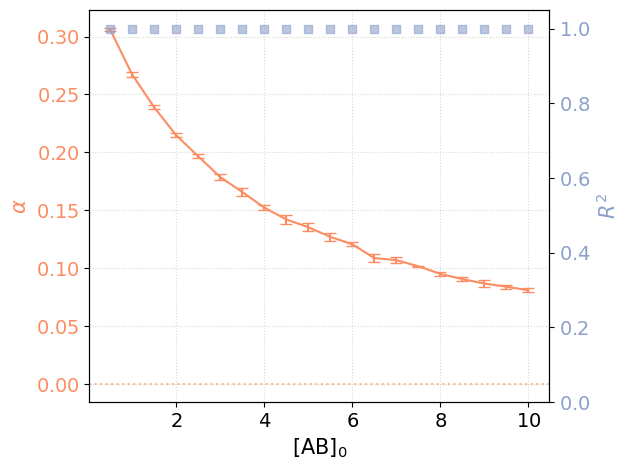

In [17]:
results = load_streamed_pickle("barrido_ab0_k1_0.0001_parallel.pkl")
results.pop(0.0)
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(r'$[\text{AB}]_0$', fontsize= label_fs) 
ax1.set_ylabel(r'$\alpha$', color=colors[1], fontsize= label_fs)

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], 
             color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1], labelsize= tick_fs)
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
# ax1.set_yscale('log')
ax1.tick_params(axis= "x", labelsize= tick_fs)

# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2], fontsize= label_fs)  
ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2], labelsize= tick_fs)
ax2.set_ylim((0, 1.05))
# ax2.set_xscale('log')
ax2.tick_params(axis= "x", labelsize= tick_fs)
fig.tight_layout()
plt.show()

In [18]:
for el in [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]:
    results.pop(el)

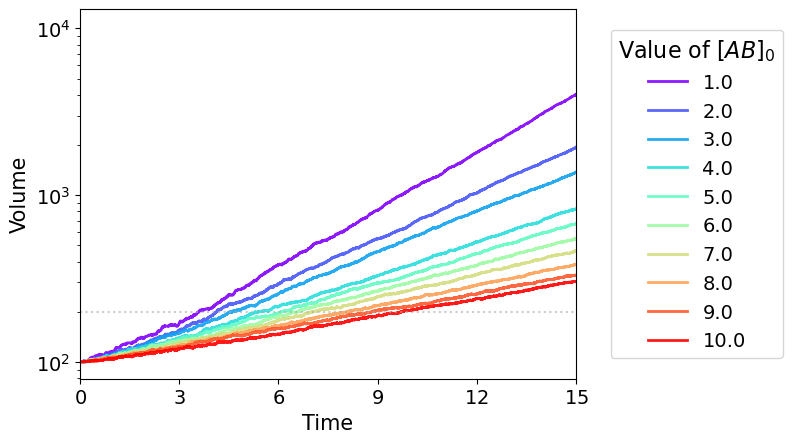

In [19]:
plot_all_volumes_AB(results, xlim= 15)

Successfully loaded 21 simulation results.
    Condition  Alpha_mean  Alpha_std   R2_mean
0         5.0    0.133640   0.003610  0.999536
1        10.0    0.080653   0.002621  0.999049
2        15.0    0.057928   0.002917  0.998416
3        20.0    0.044433   0.001852  0.998419
4        25.0    0.036445   0.000744  0.998387
5        30.0    0.030391   0.001175  0.998248
6        35.0    0.026548   0.000925  0.997913
7        40.0    0.023609   0.001000  0.998254
8        45.0    0.021248   0.000517  0.997425
9        50.0    0.019025   0.000526  0.997945
10       55.0    0.017127   0.000781  0.998187
11       60.0    0.016031   0.000720  0.997682
12       65.0    0.015033   0.000258  0.998687
13       70.0    0.013983   0.000394  0.998995
14       75.0    0.012813   0.000366  0.998592
15       80.0    0.012006   0.000347  0.998618
16       85.0    0.011136   0.000383  0.998275
17       90.0    0.010833   0.000234  0.999002
18       95.0    0.010257   0.000275  0.998511
19      100.0    

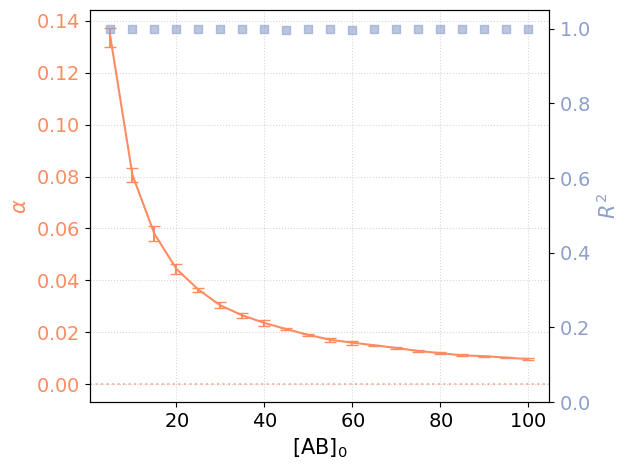

In [20]:
results = load_streamed_pickle("barrido_ab0_k1_0.0001_highiter.pkl")
results.pop(0.0)
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(r'$[\text{AB}]_0$', fontsize= label_fs) 
ax1.set_ylabel(r'$\alpha$', color=colors[1], fontsize= label_fs)

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], 
             color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1], labelsize= tick_fs)
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
# ax1.set_xscale('log')
ax1.tick_params(axis= "x", labelsize= tick_fs)

# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2], fontsize= label_fs)  
ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2], labelsize= tick_fs)
ax2.set_ylim((0, 1.05))
# ax2.set_xscale('log')
ax2.tick_params(axis= "x", labelsize= tick_fs)
fig.tight_layout()
plt.show()

In [21]:
fordeleting = 10 * np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
for el in fordeleting:
    results.pop(el)

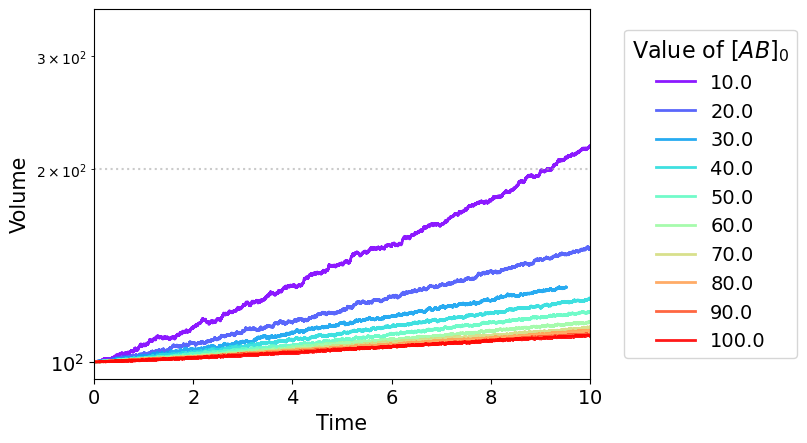

In [22]:

plot_all_volumes_AB(results, xlim=10)

#### k1 = 1

Successfully loaded 21 simulation results.
    Condition  Alpha_mean  Alpha_std   R2_mean
0         0.5    0.235082   0.003067  0.999814
1         1.0    0.179805   0.002246  0.999511
2         1.5    0.139770   0.002822  0.999556
3         2.0    0.101605   0.001668  0.998337
4         2.5    0.068495   0.002961  0.996236
5         3.0    0.042561   0.003889  0.991992
6         3.5    0.019368   0.005173  0.972926
7         4.0   -0.000323   0.002587  0.311151
8         4.5   -0.012162   0.006562  0.872155
9         5.0   -0.028290   0.005499  0.956616
10        5.5   -0.040721   0.004302  0.961251
11        6.0   -0.054175   0.009210  0.947396
12        6.5   -0.065092   0.004014  0.989337
13        7.0   -0.075407   0.008351  0.978358
14        7.5   -0.084606   0.006447  0.969608
15        8.0   -0.098894   0.003262  0.991445
16        8.5   -0.104834   0.004373  0.989172
17        9.0   -0.114171   0.010711  0.986709
18        9.5   -0.120338   0.010105  0.987470
19       10.0   -

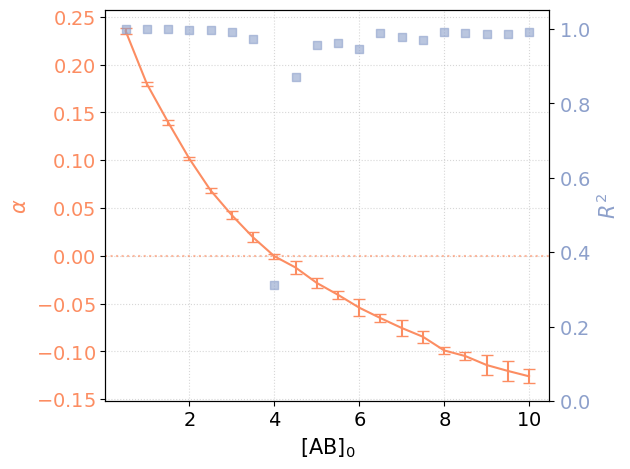

In [23]:
results = load_streamed_pickle("barrido_ab0_k1_1_parallel.pkl")
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
for el in [0.0]:
    results.pop(el)
    


stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(r'$[\text{AB}]_0$', fontsize= label_fs) 
ax1.set_ylabel(r'$\alpha$', color=colors[1], fontsize= label_fs)

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1], labelsize= tick_fs)
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
# ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=tick_fs)  

# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2], fontsize= label_fs)  
ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2], labelsize= tick_fs)
ax2.set_ylim((0, 1.05))
# ax2.set_xscale('log')
ax2.tick_params(axis='x', labelsize=tick_fs)  
fig.tight_layout()
plt.show()

In [24]:
for el in [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]:
    results.pop(el)

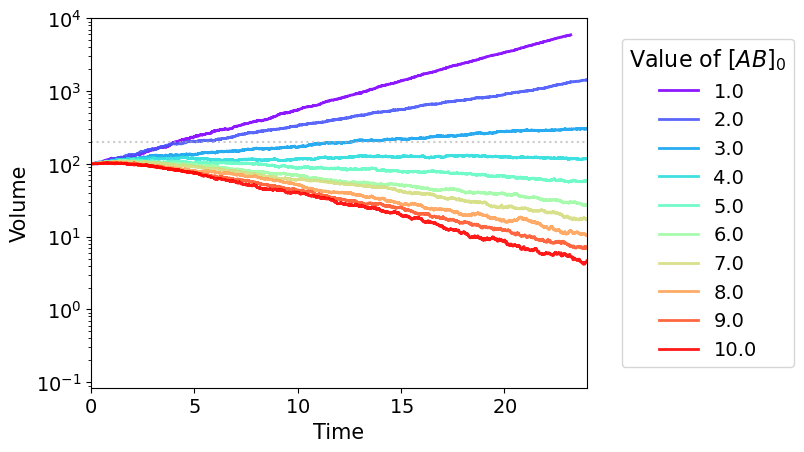

In [25]:
plot_all_volumes_AB(results, xlim = 24)

#### k1 = 1e4

Successfully loaded 21 simulation results.
    Condition  Alpha_mean  Alpha_std   R2_mean
0         0.5    0.002083   0.003144  0.124845
1         1.0   -0.011704   0.001695  0.597405
2         1.5   -0.026596   0.003988  0.682696
3         2.0   -0.038766   0.002654  0.681069
4         2.5   -0.060916   0.004217  0.742274
5         3.0   -0.078469   0.004119  0.762911
6         3.5   -0.099929   0.001639  0.786634
7         4.0   -0.120623   0.004689  0.804394
8         4.5   -0.148354   0.018543  0.829783
9         5.0   -0.186882   0.015534  0.871091
10        5.5   -0.218747   0.016963  0.892151
11        6.0   -0.269396   0.008560  0.960612
12        6.5   -0.318253   0.006394  0.970826
13        7.0   -0.353777   0.016855  0.976534
14        7.5   -0.377352   0.018228  0.981334
15        8.0   -0.380154   0.015509  0.975079
16        8.5   -0.407163   0.015946  0.974366
17        9.0   -0.415850   0.018054  0.974202
18        9.5   -0.419834   0.026438  0.961845
19       10.0   -

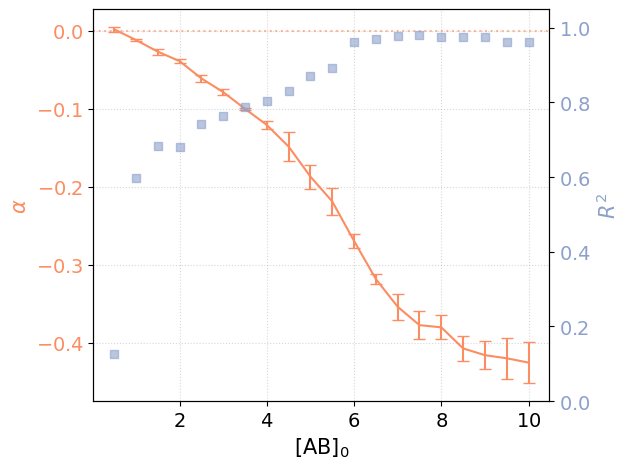

In [26]:
results = load_streamed_pickle("barrido_ab0_k1_10000.0_parallel.pkl")
results.pop(0.0)
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple, values_used= 0.1) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates, values_used= 0.1) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(r'$[\text{AB}]_0$', fontsize= label_fs) 
ax1.set_ylabel(r'$\alpha$', color=colors[1], fontsize= label_fs)

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1], labelsize= tick_fs)
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
# ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=tick_fs)  

# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2], fontsize= label_fs)  
ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2], labelsize= tick_fs)
ax2.set_ylim((0, 1.05))
# ax2.set_xscale('log')
ax2.tick_params(axis='x', labelsize=tick_fs)  
fig.tight_layout()
plt.show()

In [27]:
for el in [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]:
    results.pop(el)


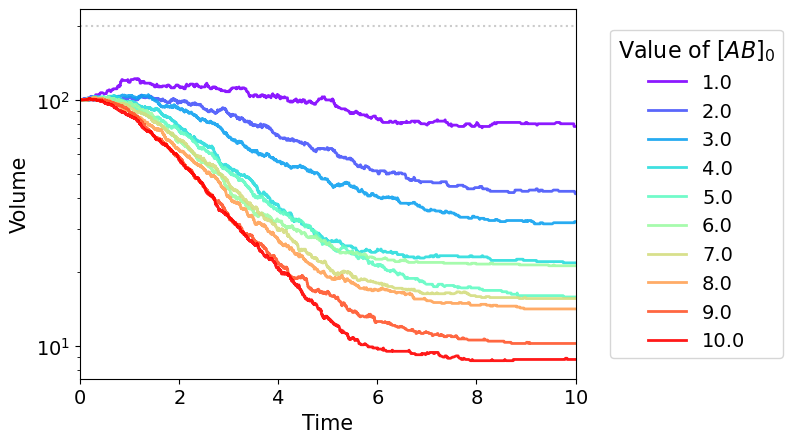

In [28]:
plot_all_volumes_AB(results, xlim=10)

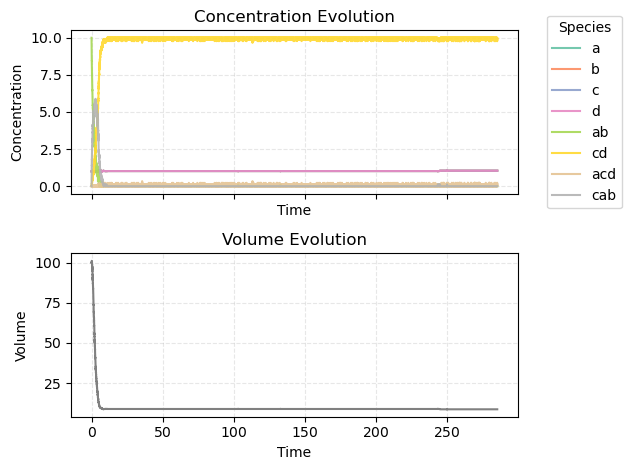

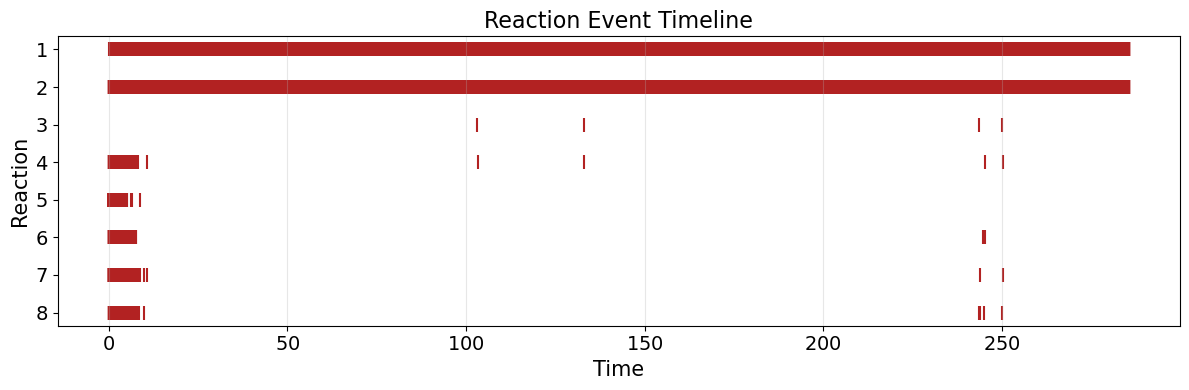

In [29]:
a,t,v = results[10.0][0]

plot(a, t, v, species)
plot_reaction_timeline(t, reaction_history=identify_reaction_history(a, c_matrix(read_file(f),species, get_header(f))), reaction_labels=range(1,9))

## k2 = 1e-4

Successfully loaded 19 simulation results.
    Condition  Alpha_mean  Alpha_std   R2_mean
0         0.5    0.000092   0.000087  0.369160
1         1.0    0.000046   0.000061  0.080716
2         1.5    0.000029   0.000037  0.269206
3         2.0   -0.000007   0.000012 -2.156712
4         2.5   -0.000005   0.000007  0.059916
5         3.0    0.000004   0.000019  0.520043
6         3.5   -0.000010   0.000006  0.628639
7         4.0   -0.000009   0.000004  0.601317
8         4.5   -0.000012   0.000009  0.626451
9         5.0   -0.000017   0.000005  0.838342
10        5.5   -0.000020   0.000005  0.906618
11        6.0   -0.000009   0.000005  0.630597
12        6.5   -0.000024   0.000010  0.928426
13        7.0   -0.000010   0.000007  0.659882
14        7.5   -0.000013   0.000004  0.856136
15        8.0   -0.000020   0.000008  0.867596
16        8.5   -0.000024   0.000008  0.914490
17        9.0   -0.000017   0.000011  0.745217


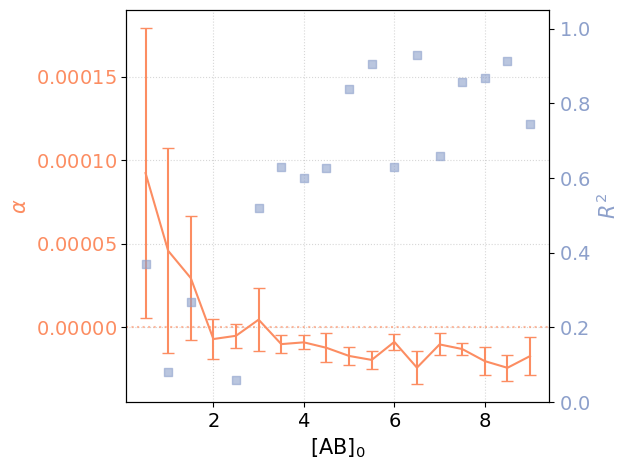

In [28]:
results = load_streamed_pickle("barrido_ab0_k2_0.0001_parallel.pkl")
results.pop(0.0)
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(r'$[\text{AB}]_0$', fontsize= label_fs) 
ax1.set_ylabel(r'$\alpha$', color=colors[1], fontsize= label_fs)

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1], labelsize= tick_fs)
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
# ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=tick_fs)  

# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2], fontsize= label_fs)  
ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2], labelsize= tick_fs)
ax2.set_ylim((0, 1.05))
# ax2.set_xscale('log')
ax2.tick_params(axis='x', labelsize=tick_fs)  
fig.tight_layout()
plt.show()

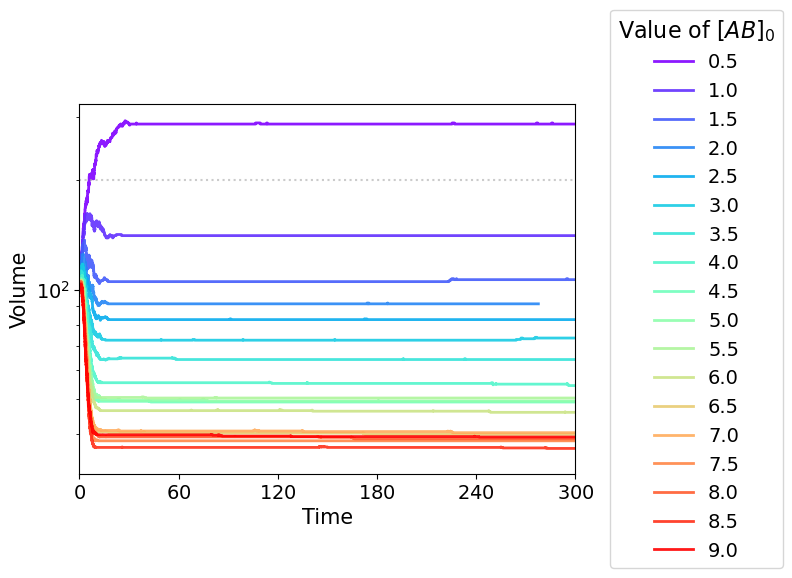

In [32]:
plot_all_volumes_AB(results, xlim = 300)

## k2 = 1

Successfully loaded 21 simulation results.
    Condition  Alpha_mean  Alpha_std   R2_mean
0         0.5    0.235475   0.002461  0.999822
1         1.0    0.180273   0.003522  0.999631
2         1.5    0.133738   0.002121  0.999103
3         2.0    0.100891   0.002716  0.998841
4         2.5    0.067380   0.002558  0.997525
5         3.0    0.045587   0.001260  0.994061
6         3.5    0.021020   0.005372  0.958692
7         4.0   -0.000414   0.001690  0.183900
8         4.5   -0.015549   0.004624  0.925267
9         5.0   -0.028867   0.005601  0.941511
10        5.5   -0.037182   0.005402  0.949214
11        6.0   -0.060050   0.008122  0.976792
12        6.5   -0.059633   0.005999  0.957218
13        7.0   -0.065344   0.007782  0.943877
14        7.5   -0.068408   0.011595  0.920571
15        8.0   -0.106064   0.008032  0.988940
16        8.5   -0.103624   0.017056  0.964258
17        9.0   -0.119223   0.011312  0.985199
18        9.5   -0.115062   0.003890  0.986797
19       10.0   -

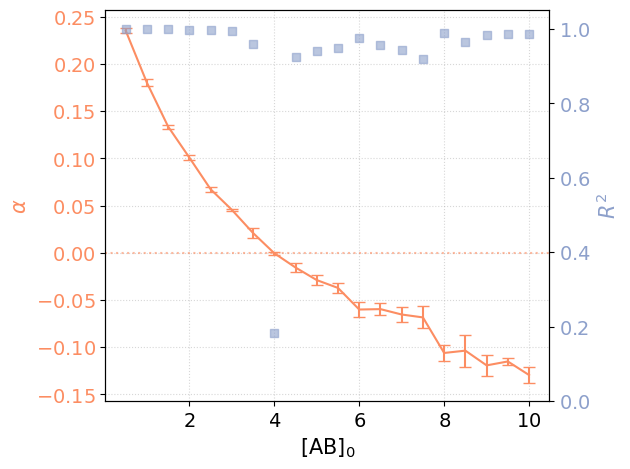

In [22]:
results = load_streamed_pickle("barrido_ab0_k2_1_parallel.pkl")
results.pop(0.0)
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(r'$[\text{AB}]_0$', fontsize= label_fs) 
ax1.set_ylabel(r'$\alpha$', color=colors[1], fontsize= label_fs)

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1], labelsize= tick_fs)
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
# ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=tick_fs)  

# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2], fontsize= label_fs)  
ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2], labelsize= tick_fs)
ax2.set_ylim((0, 1.05))
# ax2.set_xscale('log')
ax2.tick_params(axis='x', labelsize=tick_fs)  
fig.tight_layout()
plt.show()

## k2 = 1e4

Successfully loaded 21 simulation results.
    Condition  Alpha_mean  Alpha_std   R2_mean
0         0.5    0.458941   0.006209  0.999874
1         1.0    0.401254   0.007193  0.999846
2         1.5    0.352531   0.003810  0.999819
3         2.0    0.312015   0.003069  0.999713
4         2.5    0.281685   0.004785  0.999636
5         3.0    0.251155   0.007553  0.999749
6         3.5    0.230004   0.006612  0.999545
7         4.0    0.207743   0.004006  0.999402
8         4.5    0.192616   0.009932  0.999238
9         5.0    0.174288   0.004680  0.999250
10        5.5    0.164371   0.003667  0.998788
11        6.0    0.154233   0.005093  0.999482
12        6.5    0.140938   0.002738  0.998785
13        7.0    0.133619   0.003122  0.998815
14        7.5    0.124082   0.002852  0.999048
15        8.0    0.120009   0.002523  0.999000
16        8.5    0.114567   0.003415  0.998352
17        9.0    0.107525   0.004653  0.999009
18        9.5    0.099182   0.002493  0.998539
19       10.0    

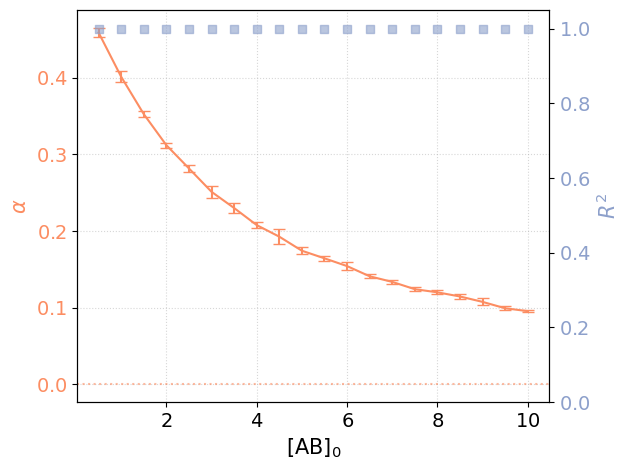

In [27]:
results = load_streamed_pickle("barrido_ab0_k2_10000.0_parallel.pkl")
results.pop(0.0)
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(r'$[\text{AB}]_0$', fontsize= label_fs) 
ax1.set_ylabel(r'$\alpha$', color=colors[1], fontsize= label_fs)

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1], labelsize= tick_fs)
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=tick_fs)  

# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2], fontsize= label_fs)  
ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2], labelsize= tick_fs)
ax2.set_ylim((0, 1.05))
# ax2.set_xscale('log')
ax2.tick_params(axis='x', labelsize=tick_fs)  
fig.tight_layout()
plt.show()

# Drago: bucle para ver todos los resultados

Successfully loaded 25 simulation results.
       Condition    Alpha_mean     Alpha_std   R2_mean
0   1.000000e-05  1.391327e-07  2.897406e-07  0.417354
1   3.162278e-05  5.665618e-07  1.079999e-06  0.492715
2   1.000000e-04  5.808782e-07  3.238283e-06  0.379916
3   3.162278e-04 -3.872036e-07  1.720125e-05  0.499598
4   1.000000e-03  3.605827e-05  2.916272e-05  0.490356
5   3.162278e-03 -2.161003e-05  1.341952e-04  0.480896
6   1.000000e-02  1.390989e-04  4.278553e-04  0.450046
7   3.162278e-02  1.468690e-03  1.234875e-03  0.503540
8   1.000000e-01  1.213859e-02  3.823814e-03  0.923647
9   3.162278e-01  6.954569e-02  1.246276e-02  0.979055
10  1.000000e+00  1.862915e-01  1.190071e-02  0.997458
11  3.162278e+00  3.240470e-01  1.754102e-02  0.998879
12  1.000000e+01  4.289303e-01  1.628181e-02  0.999224
13  3.162278e+01  4.932600e-01  2.043525e-02  0.999130
14  1.000000e+02  5.161669e-01  1.496416e-02  0.999445
15  3.162278e+02  5.307860e-01  1.792672e-02  0.999510
16  1.000000e+03  5.21

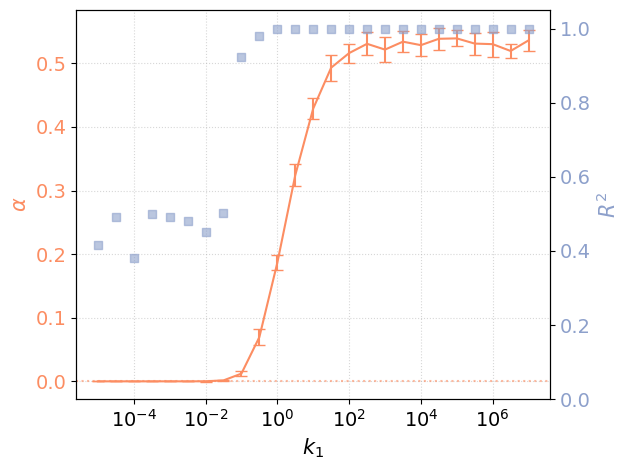

Successfully loaded 25 simulation results.
       Condition  Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05    0.265935   0.005922  0.999091
1   3.162278e-05    0.268304   0.009865  0.999228
2   1.000000e-04    0.271158   0.007489  0.998950
3   3.162278e-04    0.270137   0.007612  0.998859
4   1.000000e-03    0.264749   0.009201  0.998879
5   3.162278e-03    0.274025   0.008966  0.999031
6   1.000000e-02    0.261637   0.005051  0.998955
7   3.162278e-02    0.268226   0.005849  0.999146
8   1.000000e-01    0.256292   0.008242  0.999118
9   3.162278e-01    0.235213   0.006444  0.998237
10  1.000000e+00    0.184056   0.009229  0.996914
11  3.162278e+00    0.082579   0.006169  0.984895
12  1.000000e+01    0.015290   0.005310  0.818202
13  3.162278e+01   -0.001092   0.003770  0.408518
14  1.000000e+02   -0.000482   0.001449  0.269465
15  3.162278e+02    0.000083   0.000815  0.326112
16  1.000000e+03   -0.000162   0.000981  0.395484
17  3.162278e+03    0.000035   0.000423 -0.477247
18  1.0

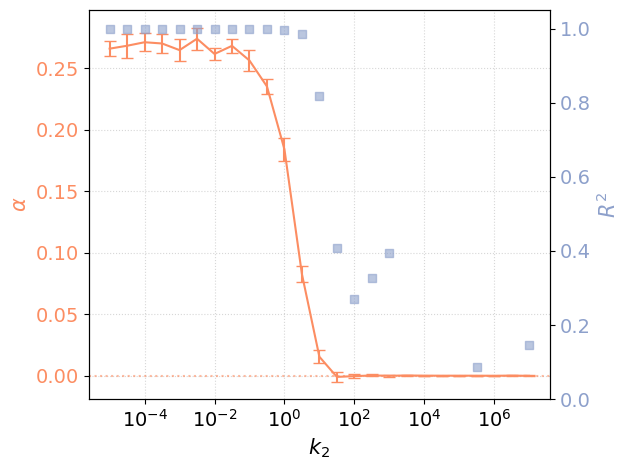

Successfully loaded 25 simulation results.
       Condition  Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05   -0.000114   0.000098 -0.885545
1   3.162278e-05   -0.000154   0.000223  0.287065
2   1.000000e-04   -0.000021   0.000106  0.095771
3   3.162278e-04    0.000285   0.000500  0.281893
4   1.000000e-03    0.000167   0.000406  0.259112
5   3.162278e-03    0.000865   0.000994  0.450755
6   1.000000e-02    0.002631   0.001501  0.667566
7   3.162278e-02    0.008284   0.002284  0.903998
8   1.000000e-01    0.027311   0.003324  0.977085
9   3.162278e-01    0.088775   0.005771  0.995437
10  1.000000e+00    0.180702   0.007008  0.997446
11  3.162278e+00    0.284064   0.012754  0.998690
12  1.000000e+01    0.356828   0.011102  0.998946
13  3.162278e+01    0.380462   0.020529  0.998873
14  1.000000e+02    0.393897   0.013582  0.998899
15  3.162278e+02    0.400695   0.014190  0.999201
16  1.000000e+03    0.394743   0.014539  0.998310
17  3.162278e+03    0.397729   0.013798  0.998542
18  1.0

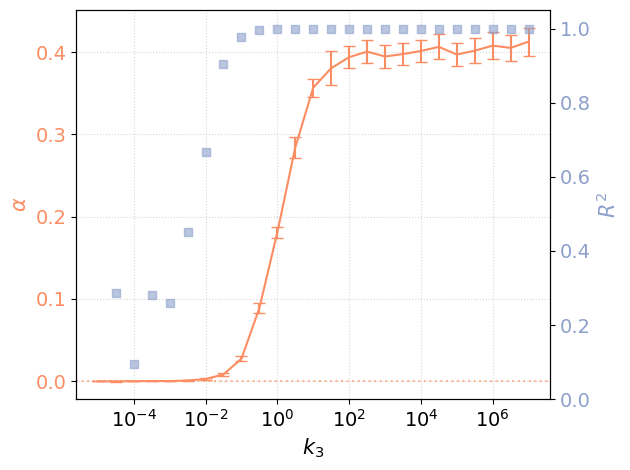

Successfully loaded 25 simulation results.
       Condition    Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05  2.372854e-01   0.009801  0.998894
1   3.162278e-05  2.379201e-01   0.006117  0.998591
2   1.000000e-04  2.395950e-01   0.007755  0.998907
3   3.162278e-04  2.374390e-01   0.007420  0.998553
4   1.000000e-03  2.323394e-01   0.004869  0.998499
5   3.162278e-03  2.338872e-01   0.011775  0.998667
6   1.000000e-02  2.350760e-01   0.008053  0.998963
7   3.162278e-02  2.325282e-01   0.010667  0.998857
8   1.000000e-01  2.324383e-01   0.005455  0.998844
9   3.162278e-01  2.205108e-01   0.004676  0.998679
10  1.000000e+00  1.822838e-01   0.009344  0.998006
11  3.162278e+00  9.846908e-02   0.008089  0.990495
12  1.000000e+01  2.898413e-02   0.005760  0.952587
13  3.162278e+01  8.543162e-03   0.001464  0.874828
14  1.000000e+02  3.591143e-03   0.002140  0.684806
15  3.162278e+02  2.617666e-04   0.000698  0.210504
16  1.000000e+03  1.054274e-04   0.000452  0.182105
17  3.162278e+03  5.3

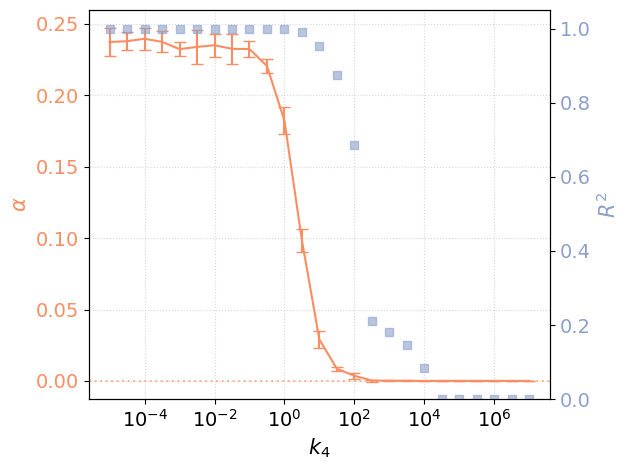

Successfully loaded 25 simulation results.
       Condition    Alpha_mean     Alpha_std   R2_mean
0   1.000000e-05  2.224737e-08  3.199534e-07  0.406745
1   3.162278e-05 -2.463985e-07  1.618482e-06  0.532253
2   1.000000e-04  7.445743e-07  3.917429e-06  0.489588
3   3.162278e-04  5.611339e-06  1.160879e-05  0.412486
4   1.000000e-03  1.770257e-05  4.436342e-05  0.512993
5   3.162278e-03 -3.029362e-06  1.336496e-04  0.445804
6   1.000000e-02  1.074308e-04  2.759522e-04  0.395316
7   3.162278e-02  1.864769e-03  8.950466e-04  0.695959
8   1.000000e-01  1.418097e-02  3.899645e-03  0.949222
9   3.162278e-01  6.461883e-02  5.599189e-03  0.986965
10  1.000000e+00  1.843449e-01  8.851412e-03  0.997277
11  3.162278e+00  3.186059e-01  1.330353e-02  0.998704
12  1.000000e+01  4.400575e-01  9.773428e-03  0.999260
13  3.162278e+01  4.949604e-01  1.353560e-02  0.999272
14  1.000000e+02  5.132358e-01  9.973599e-03  0.999260
15  3.162278e+02  5.334906e-01  2.001323e-02  0.999301
16  1.000000e+03  5.22

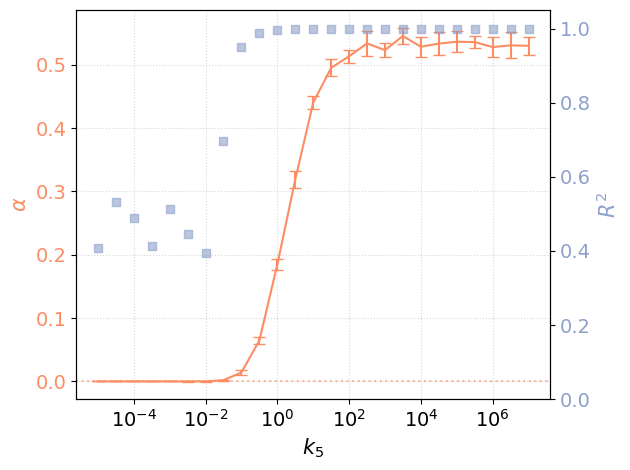

Successfully loaded 25 simulation results.
       Condition  Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05    0.268575   0.007993  0.999317
1   3.162278e-05    0.270378   0.007142  0.998696
2   1.000000e-04    0.269798   0.005147  0.999072
3   3.162278e-04    0.269292   0.007168  0.999110
4   1.000000e-03    0.271925   0.007632  0.999214
5   3.162278e-03    0.267876   0.006008  0.999076
6   1.000000e-02    0.269174   0.004828  0.999208
7   3.162278e-02    0.266729   0.005642  0.999040
8   1.000000e-01    0.257058   0.008324  0.999027
9   3.162278e-01    0.233697   0.008046  0.998682
10  1.000000e+00    0.181089   0.007457  0.997544
11  3.162278e+00    0.078869   0.010838  0.988630
12  1.000000e+01    0.016721   0.009838  0.766380
13  3.162278e+01    0.000616   0.004614  0.493275
14  1.000000e+02    0.000269   0.001242  0.226414
15  3.162278e+02    0.000064   0.000915  0.294662
16  1.000000e+03   -0.000028   0.000477  0.216642
17  3.162278e+03   -0.000164   0.000347  0.149163
18  1.0

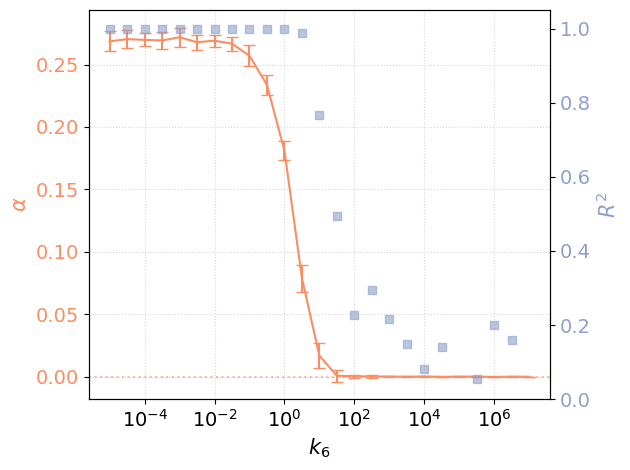

Successfully loaded 25 simulation results.
       Condition  Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05    0.000059   0.000303  0.254989
1   3.162278e-05    0.000055   0.000229  0.153158
2   1.000000e-04    0.000063   0.000195 -0.129422
3   3.162278e-04   -0.000051   0.000390  0.299281
4   1.000000e-03    0.000447   0.000444  0.496209
5   3.162278e-03    0.000187   0.000404  0.249389
6   1.000000e-02    0.002027   0.001057  0.706820
7   3.162278e-02    0.007514   0.001876  0.927679
8   1.000000e-01    0.027029   0.003430  0.970874
9   3.162278e-01    0.085906   0.004229  0.993034
10  1.000000e+00    0.180717   0.006244  0.997591
11  3.162278e+00    0.282519   0.013901  0.998662
12  1.000000e+01    0.354058   0.020886  0.998669
13  3.162278e+01    0.391025   0.011608  0.998938
14  1.000000e+02    0.391588   0.009678  0.998896
15  3.162278e+02    0.393176   0.007440  0.999186
16  1.000000e+03    0.399233   0.014317  0.998799
17  3.162278e+03    0.400827   0.011920  0.998929
18  1.0

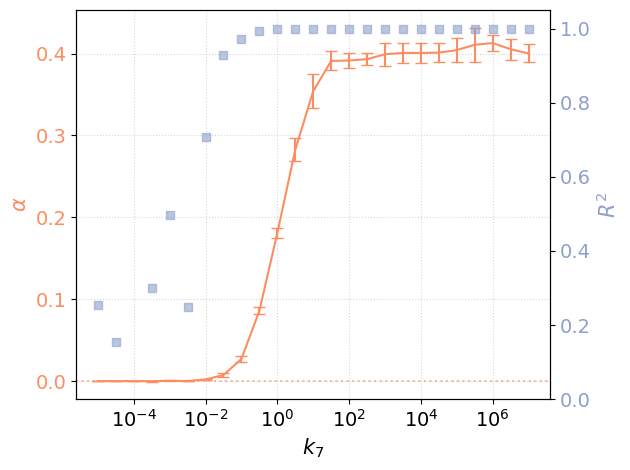

Successfully loaded 25 simulation results.
       Condition    Alpha_mean  Alpha_std   R2_mean
0   1.000000e-05  2.314055e-01   0.008279  0.998712
1   3.162278e-05  2.327017e-01   0.007635  0.998972
2   1.000000e-04  2.359762e-01   0.010732  0.998704
3   3.162278e-04  2.398044e-01   0.008930  0.998490
4   1.000000e-03  2.334139e-01   0.009092  0.998454
5   3.162278e-03  2.339199e-01   0.008429  0.998866
6   1.000000e-02  2.381669e-01   0.005146  0.998883
7   3.162278e-02  2.285814e-01   0.008682  0.998822
8   1.000000e-01  2.297581e-01   0.007822  0.998436
9   3.162278e-01  2.197511e-01   0.009690  0.998608
10  1.000000e+00  1.814137e-01   0.010201  0.998216
11  3.162278e+00  1.053880e-01   0.009620  0.994153
12  1.000000e+01  3.175451e-02   0.004387  0.952554
13  3.162278e+01  7.795515e-03   0.003379  0.788356
14  1.000000e+02  1.862741e-03   0.002116  0.532895
15  3.162278e+02  1.465475e-03   0.000865  0.524434
16  1.000000e+03  3.296581e-04   0.000410  0.220551
17  3.162278e+03  3.3

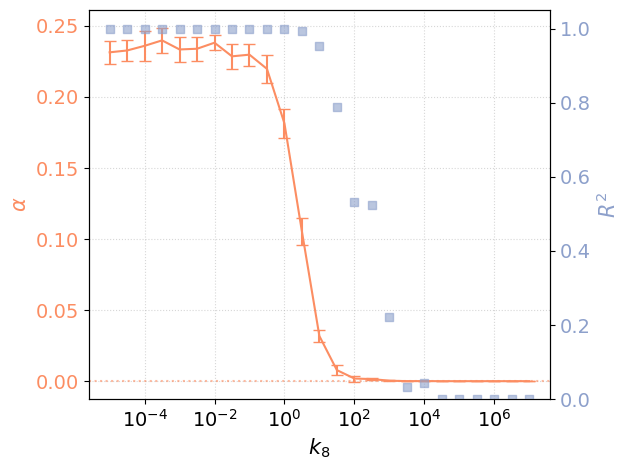

In [ ]:
for i in range(0,8):
    results = load_streamed_pickle(f"barrido_k{i}_highiter.pkl")
    results.keys()
    len(results)
    # 1. Processing the statistical data
    # Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
    stats_results = []

    for condition, replicates in results.items():
        alphas = []
        r2_values = []
        if not isinstance(replicates, tuple):
            for rep in replicates:
                # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
                if isinstance(rep, dict):
                    # This gets the first value in the dict, which is your (ab, t, v) tuple
                    data_tuple = list(rep.values())[0]
                else:
                    data_tuple = rep
                    
                res = get_alpha_single_run(condition, data_tuple) 
                alphas.append(res['Alpha'])
                r2_values.append(res['R^2'])
        else:
            res = get_alpha_single_run(condition, replicates) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
        
        stats_results.append({
            'Condition': condition,
            'Alpha_mean': np.mean(alphas),
            'Alpha_std': np.std(alphas),
            'R2_mean': np.mean(r2_values)
        })

    # Convert to DataFrame or Sortable List for plotting
    stats_results = pd.DataFrame(stats_results).sort_values('Condition')
    print(stats_results)

    # 2. Plotting with Error Bars
    fig, ax1 = plt.subplots()

    # Primary Axis: Alpha with Error Bars
    # if i == 0 or i == 1:
    #     j = 1
    # elif i == 2 or i == 3:
    #     j = 2
    # elif i == 4 or i == 5:
    #     j = 3
    # elif i == 6 or i == 7:
    #     j = 4
    
    # ax1.set_xlabel(fr'$K_{j}$', fontsize= label_fs)
    ax1.set_xlabel(fr'$k_{i+1}$', fontsize= label_fs)
    ax1.set_ylabel(r'$\alpha$', color=colors[1], fontsize= label_fs)

    ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
                yerr=stats_results['Alpha_std'], color=colors[1], capsize=4, label=r'Mean $\alpha$')
    # ax1.plot(stats_results['Condition'], stats_results['Alpha_mean'], color=colors[1])

    ax1.tick_params(axis='y', labelcolor=colors[1], labelsize= tick_fs)
    ax1.grid(True, linestyle=':', alpha=0.5, which='both')
    ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
    ax1.set_xscale('log')
    ax1.tick_params(axis= 'x', labelsize= tick_fs)
    # ax1.set_yscale('log')

    # Secondary Axis: R^2
    ax2 = ax1.twinx()  
    ax2.set_ylabel(r'$R^2$', color=colors[2], fontsize= label_fs)  
    ax2.scatter(stats_results['Condition'], stats_results['R2_mean'], 
                color=colors[2], marker='s', alpha=0.6)

    ax2.tick_params(axis='y', labelcolor=colors[2], labelsize= tick_fs)
    ax2.set_ylim((0, 1.05))
    ax2.set_xscale('log')
    ax2.tick_params(axis= 'x', labelsize= tick_fs)

    fig.tight_layout()
    plt.show()

## uno a uno

Successfully loaded 25 simulation results.
dict_keys([1e-05, 3.1622776601683795e-05, 0.0001, 0.00031622776601683794, 0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0, 3162.2776601683795, 10000.0, 31622.776601683792, 100000.0, 316227.7660168379, 1000000.0, 3162277.6601683795, 10000000.0])
       Condition  Alpha_mean  Alpha_std    R2_mean
0   1.000000e-05    0.000001   0.000004 -17.115687
1   3.162278e-05    0.000002   0.000012 -13.466498
2   1.000000e-04   -0.000007   0.000042   0.363517
3   3.162278e-04    0.000071   0.000087   0.454597
4   1.000000e-03    0.000277   0.000113   0.744728
5   3.162278e-03    0.000881   0.000226   0.913965
6   1.000000e-02    0.002718   0.000664   0.960849
7   3.162278e-02    0.008394   0.001122   0.990847
8   1.000000e-01    0.028607   0.002158   0.996881
9   3.162278e-01    0.082852   0.003184   0.999096
10  1.000000e+00    0.179467   

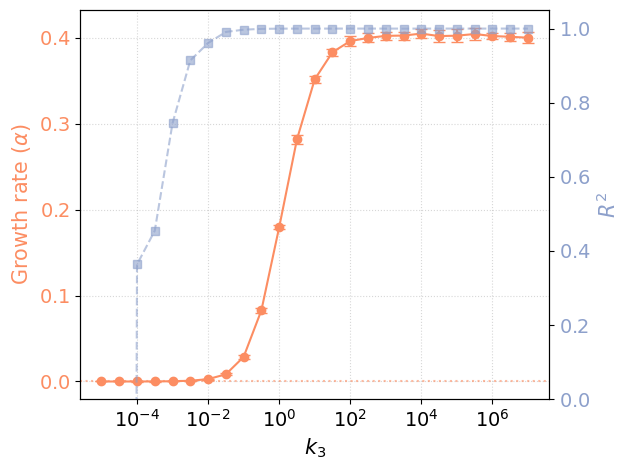

In [91]:
i = 2 # from 0 to 7
results = load_streamed_pickle(f"barrido_k{i}_highiter.pkl")
print(results.keys())
len(results)
# 1. Processing the statistical data
# Assuming barrido_ab_k1_em4 is a dict: {concentration: [(ab, t, v), (ab, t, v), ...]}
stats_results = []

for condition, replicates in results.items():
    alphas = []
    r2_values = []
    if not isinstance(replicates, tuple):
        for rep in replicates:
            # If rep is a dictionary {cond: (ab, t, v)}, get the tuple:
            if isinstance(rep, dict):
                # This gets the first value in the dict, which is your (ab, t, v) tuple
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            r2_values.append(res['R^2'])
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        r2_values.append(res['R^2'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'R2_mean': np.mean(r2_values)
    })

# Convert to DataFrame or Sortable List for plotting
stats_results = pd.DataFrame(stats_results).sort_values('Condition')
print(stats_results)

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha with Error Bars
ax1.set_xlabel(rf'$k_{i +1}$', fontsize= label_fs) 
ax1.set_ylabel(r'Growth rate ($\alpha)$', color=colors[1], fontsize= label_fs)

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
            yerr=stats_results['Alpha_std'], 
            fmt='o-', color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
ax1.set_xscale('log')
ax1.tick_params(axis='both', labelsize= tick_fs)


# Secondary Axis: R^2
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$R^2$', color=colors[2], fontsize= label_fs)  
ax2.plot(stats_results['Condition'], stats_results['R2_mean'], 
            color=colors[2], linestyle='--',marker='s', alpha=0.6)

ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.set_ylim((0, 1.05))
ax2.set_xscale('log')
ax2.tick_params(axis='both', labelsize= tick_fs)

fig.tight_layout()
plt.show()

C:\Users\cvzad\AppData\Local\Temp\ipykernel_39852\2527390737.py:31: RuntimeWarning: Mean of empty slice
  'Td_mean': np.nanmean(doubling_times),
c:\Users\cvzad\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


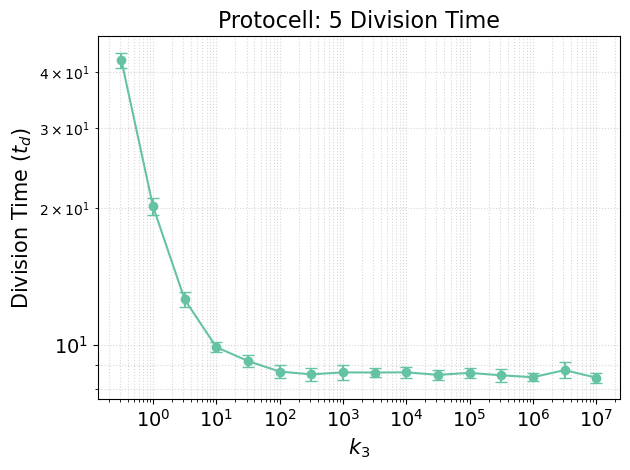

In [92]:
plot_division_single_k(results, i, 5)

In [93]:
# TODO: ELIMINAR 3.2 DE LOS VOLÚMENES
# TODO: VER SOLO VOLUMENES QUE NO CRECEN CON UN RANGO DE TIEMPO MAYOR

In [94]:
# keys_to_delete = [k for k in results if '3' in str(k)]

# for k in keys_to_delete:
#     del results[k]

In [95]:
results.keys()

dict_keys([1e-05, 3.1622776601683795e-05, 0.0001, 0.00031622776601683794, 0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0, 3162.2776601683795, 10000.0, 31622.776601683792, 100000.0, 316227.7660168379, 1000000.0, 3162277.6601683795, 10000000.0])

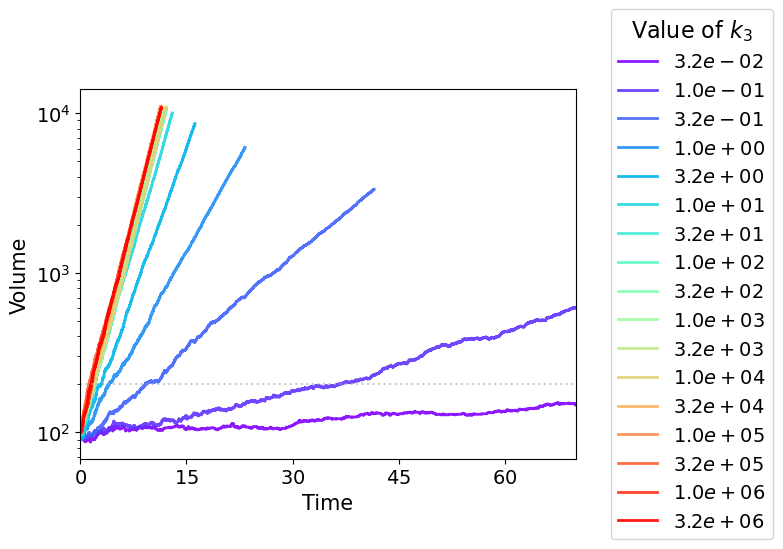

In [103]:

plot_all_volumes(results, i, 
                 xlim=70, 
                 lim= (1e-2, 1e7),
                 )

Regression completed. Fitted Scaling Constant A: 71.433
Fitted exponential rate m (alpha): 0.010
Coefficient of Determination (R^2): 0.9940


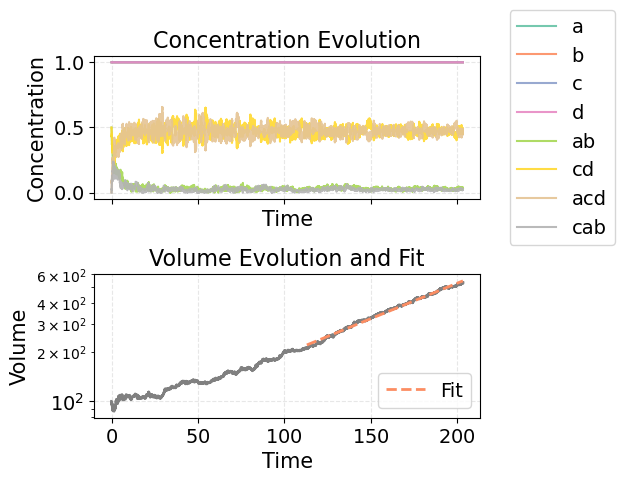

Plot generated successfully.


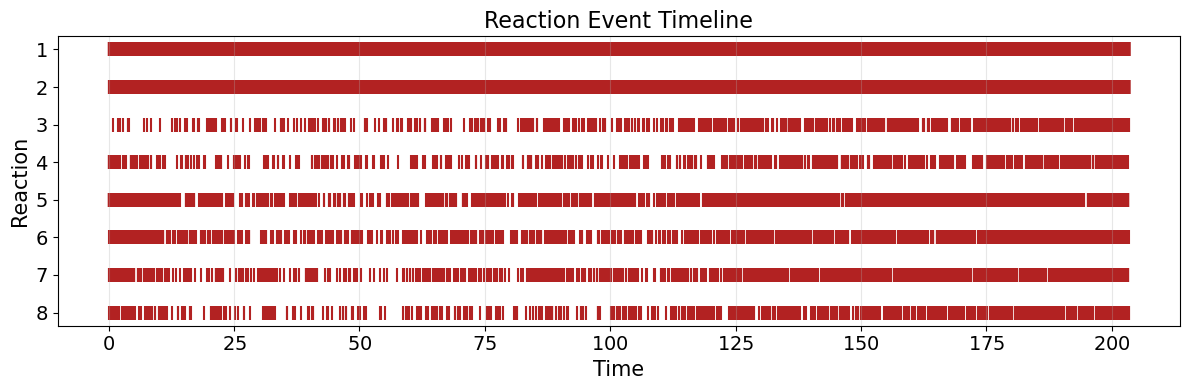

In [101]:
a,t,v = results[0.03162277660168379][0]
plot_ajuste(a,t,v,species)
plot_reaction_timeline(t, range(1,9), a)

# stats

Successfully loaded 25 simulation results.


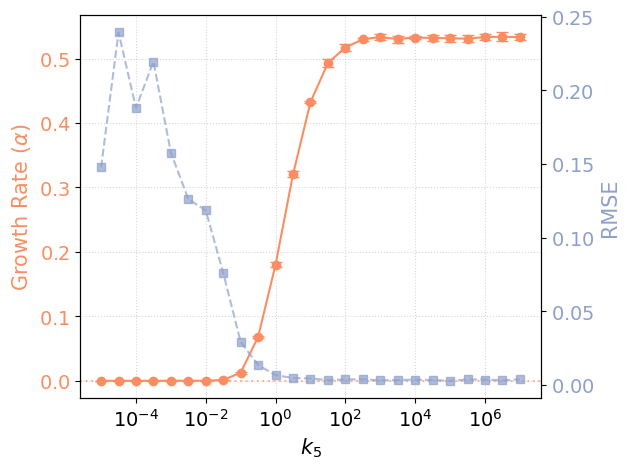

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

i = 4
results = load_streamed_pickle(f"barrido_k{i}_highiter.pkl")

# 1. Processing the statistical data
stats_results = []

for condition, replicates in results.items():
    alphas = []
    rmse_values = [] # Changed from r2_values
    
    if not isinstance(replicates, tuple):
        for rep in replicates:
            if isinstance(rep, dict):
                data_tuple = list(rep.values())[0]
            else:
                data_tuple = rep
                
            res = get_alpha_single_run(condition, data_tuple) 
            alphas.append(res['Alpha'])
            # Assuming get_alpha_single_run now returns 'RMSE'
            rmse_values.append(res['RMSE']) 
    else:
        res = get_alpha_single_run(condition, replicates) 
        alphas.append(res['Alpha'])
        rmse_values.append(res['RMSE'])
    
    stats_results.append({
        'Condition': condition,
        'Alpha_mean': np.mean(alphas),
        'Alpha_std': np.std(alphas),
        'RMSE_mean': np.mean(rmse_values), 
        'R^2': np.mean(res['R^2'])
    })

# Convert to DataFrame
stats_results = pd.DataFrame(stats_results).sort_values('Condition')

# 2. Plotting with Error Bars
fig, ax1 = plt.subplots()

# Primary Axis: Alpha
ax1.set_xlabel(rf'$k_{i + 1}$', fontsize= label_fs) 
ax1.set_ylabel(r'Growth Rate ($\alpha$)', color=colors[1], fontsize=label_fs)

ax1.errorbar(stats_results['Condition'], stats_results['Alpha_mean'], 
             yerr=stats_results['Alpha_std'], 
             fmt='o-', color=colors[1], capsize=4, label=r'Mean $\alpha$')

ax1.tick_params(axis='y', labelcolor=colors[1])
ax1.grid(True, linestyle=':', alpha=0.5, which='both')
ax1.axhline(y=0, color=colors[1], alpha=0.6, linestyle=":")
ax1.set_xscale('log')
ax1.tick_params(axis='both', labelsize= tick_fs)


# Secondary Axis: RMSE
ax2 = ax1.twinx()  
ax2.set_ylabel(r'RMSE', color=colors[2], fontsize=label_fs)  

# Plotting RMSE mean
ax2.plot(stats_results['Condition'], stats_results['RMSE_mean'], 
         color=colors[2], marker='s', linestyle='--', alpha=0.7, label='RMSE')

ax2.tick_params(axis='y', labelcolor=colors[2])
ax2.tick_params(axis='both', labelsize= tick_fs)
# Note: RMSE is not bounded by 1.0, so we let the axis auto-scale 
# or set it based on your typical noise levels (e.g., 0 to 0.5)
# ax2.set_ylim(bottom=0) 

fig.tight_layout()
plt.show()

In [32]:
stats_results

Condition    Alpha_mean     Alpha_std  RMSE_mean       R^2
0   1.000000e-05  7.207137e-08  6.255041e-08   0.147665  0.024854
1   3.162278e-05  1.569023e-07  5.071962e-07   0.239266  0.783610
2   1.000000e-04  1.455774e-06  1.340219e-06   0.187926  0.388989
3   3.162278e-04  1.011489e-06  3.414801e-06   0.219476  0.176113
4   1.000000e-03  6.640030e-06  1.482368e-05   0.157716  0.741878
5   3.162278e-03  7.118580e-05  4.091896e-05   0.126123  0.193716
6   1.000000e-02  2.202974e-04  9.276685e-05   0.118446  0.895513
7   3.162278e-02  1.263332e-03  3.522830e-04   0.076089  0.925037
8   1.000000e-01  1.258172e-02  1.593495e-03   0.029209  0.982903
9   3.162278e-01  6.818147e-02  1.955984e-03   0.013590  0.998844
10  1.000000e+00  1.802858e-01  3.263394e-03   0.006659  0.999703
11  3.162278e+00  3.203627e-01  4.711978e-03   0.004812  0.999895
12  1.000000e+01  4.322559e-01  1.810114e-03   0.004401  0.999681
13  3.162278e+01  4.931120e-01  5.883349e-03   0.003354  0.999920
14  1.000000e+02  5.170534e-01  5.395574e-03   0.003816  0.999922
15  3.162278e+02  5.299427e-01  2.359567e-03   0.003888  0.999872
16  1.000000e+03  5.332221e-01  4.233717e-03   0.003167  0.999889
17  3.162278e+03  5.301945e-01  5.426481e-03   0.003417  0.999964
18  1.000000e+04  5.325969e-01  2.646773e-03   0.003645  0.999898
19  3.162278e+04  5.319426e-01  5.003013e-03   0.003429  0.999945
20  1.000000e+05  5.314463e-01  5.099357e-03   0.002877  0.999948
21  3.162278e+05  5.307261e-01  5.630898e-03   0.003806  0.999869
22  1.000000e+06  5.334022e-01  4.818579e-03   0.003684  0.999900
23  3.162278e+06  5.337568e-01  6.795670e-03   0.003177  0.999964
24  1.000000e+07  5.330818e-01  4.460694e-03   0.003889  0.999935

In [33]:
from scipy import stats

# Sample list to hold results
stats_list = []

# Example loop for your simulations
for sim_id, data in results.items():
    data = data[0]
    t = data[1]
    log_v = np.log(data[2])
    
    # 1. Perform Linear Regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(t, log_v)
    
    # 2. Calculate Predicted log_v and Residuals
    log_v_pred = intercept + slope * t
    residuals = log_v - log_v_pred
    
    # 3. Calculate RMSE
    rmse = np.sqrt(np.mean(residuals**2))
    
    # 4. Append to results
    stats_list.append({
        'sim_id': sim_id,
        'growth_rate_alpha': slope,
        'r_squared': r_value**2,
        'rmse': rmse,
        'p_value': p_value
    })

# Create the DataFrame
stats_results = pd.DataFrame(stats_list)

In [34]:
stats_results

sim_id  growth_rate_alpha  r_squared      rmse  p_value
0   1.000000e-05       3.706587e-08   0.238956  0.105150      0.0
1   3.162278e-05      -2.039303e-07   0.283270  0.520401      0.0
2   1.000000e-04       2.096571e-06   0.833717  0.199429      0.0
3   3.162278e-04       6.948326e-06   0.869080  0.105833      0.0
4   1.000000e-03       1.139574e-05   0.591099  0.136314      0.0
5   3.162278e-03       7.977381e-05   0.898570  0.119952      0.0
6   1.000000e-02       1.889130e-04   0.919065  0.087456      0.0
7   3.162278e-02       1.705328e-03   0.934398  0.103801      0.0
8   1.000000e-01       1.279192e-02   0.997268  0.034080      0.0
9   3.162278e-01       7.224336e-02   0.997714  0.037284      0.0
10  1.000000e+00       1.780578e-01   0.999490  0.019760      0.0
11  3.162278e+00       3.195157e-01   0.999914  0.008132      0.0
12  1.000000e+01       4.390958e-01   0.999877  0.009888      0.0
13  3.162278e+01       4.977749e-01   0.999868  0.010304      0.0
14  1.000000e+02       5.151873e-01   0.999824  0.011941      0.0
15  3.162278e+02       5.280361e-01   0.999895  0.009220      0.0
16  1.000000e+03       5.193955e-01   0.999723  0.015188      0.0
17  3.162278e+03       5.325202e-01   0.999938  0.007114      0.0
18  1.000000e+04       5.274072e-01   0.999867  0.010401      0.0
19  3.162278e+04       5.367364e-01   0.999909  0.008634      0.0
20  1.000000e+05       5.360079e-01   0.999869  0.010428      0.0
21  3.162278e+05       5.276535e-01   0.999877  0.010071      0.0
22  1.000000e+06       5.302891e-01   0.999834  0.011660      0.0
23  3.162278e+06       5.385297e-01   0.999882  0.009831      0.0
24  1.000000e+07       5.335979e-01   0.999920  0.008194      0.0

k = 1e-05
Regression completed. Fitted Scaling Constant A: 107.896
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.0953


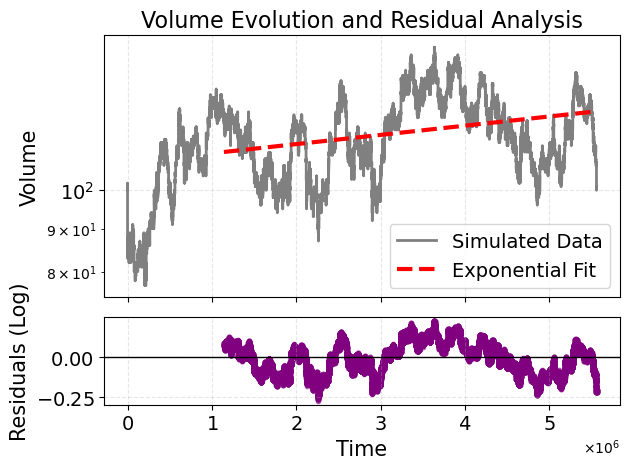

Plot with residuals generated successfully.
k = 3.1622776601683795e-05
Regression completed. Fitted Scaling Constant A: 73.906
Fitted exponential rate m (alpha): -0.000
Coefficient of Determination (R^2): 0.1786


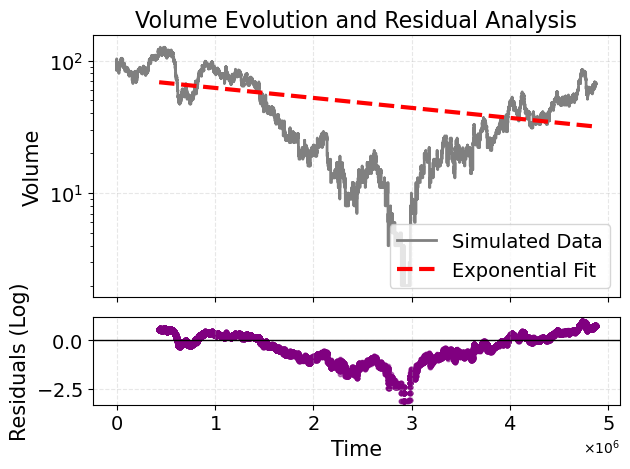

Plot with residuals generated successfully.
k = 0.0001
Regression completed. Fitted Scaling Constant A: 30.915
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.8982


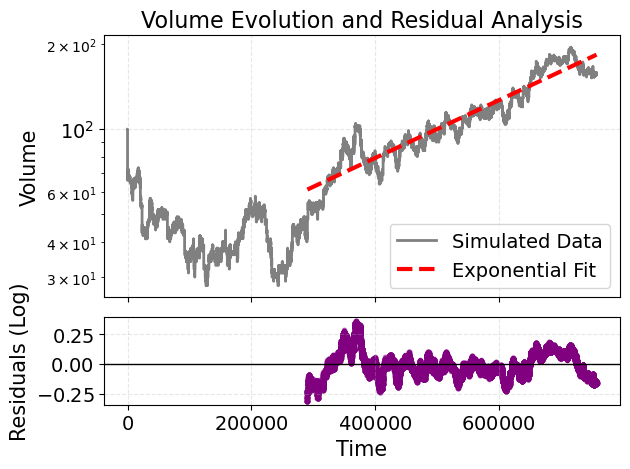

Plot with residuals generated successfully.
k = 0.00031622776601683794
Regression completed. Fitted Scaling Constant A: 86.740
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.8339


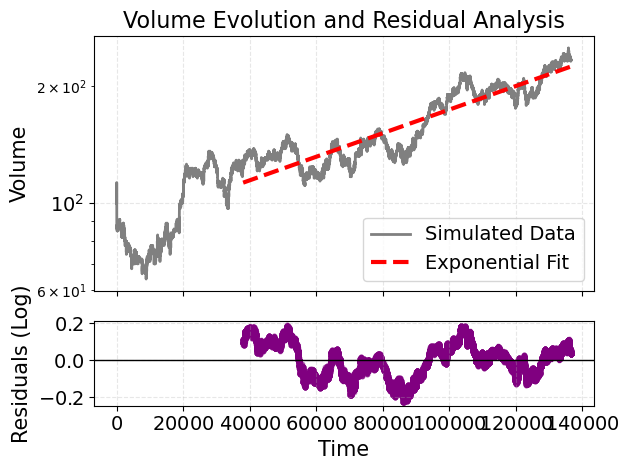

Plot with residuals generated successfully.
k = 0.001
Regression completed. Fitted Scaling Constant A: 107.418
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.2607


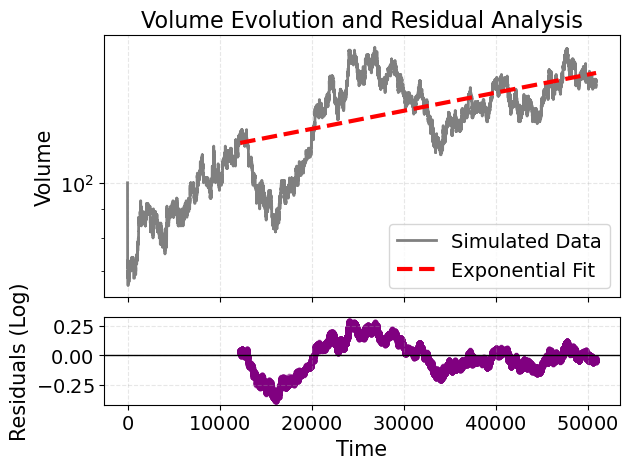

Plot with residuals generated successfully.
k = 0.0031622776601683794
Regression completed. Fitted Scaling Constant A: 61.094
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.8514


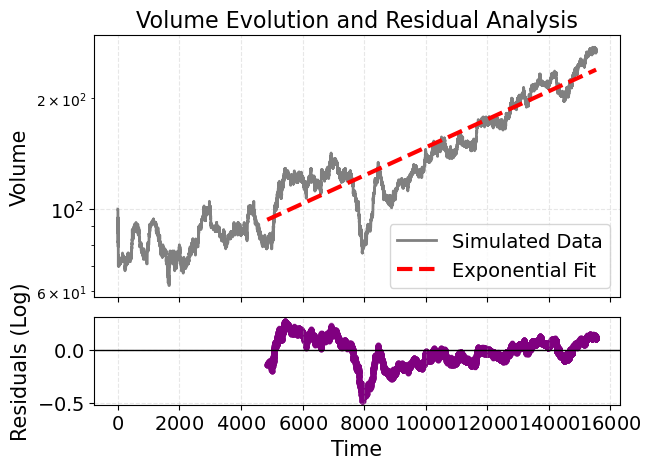

Plot with residuals generated successfully.
k = 0.01
Regression completed. Fitted Scaling Constant A: 64.151
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.9100


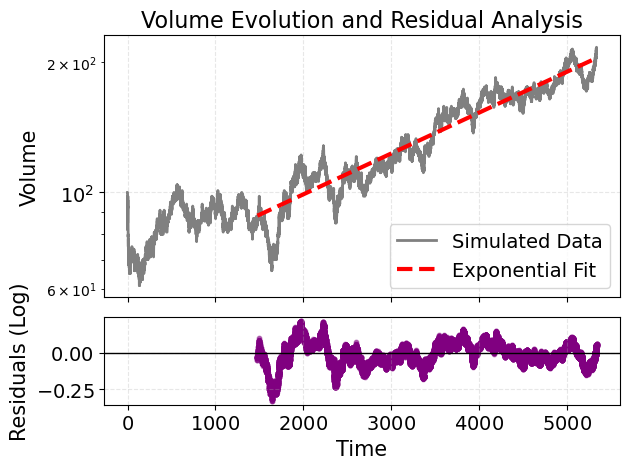

Plot with residuals generated successfully.
k = 0.03162277660168379
Regression completed. Fitted Scaling Constant A: 128.387
Fitted exponential rate m (alpha): 0.002
Coefficient of Determination (R^2): 0.9486


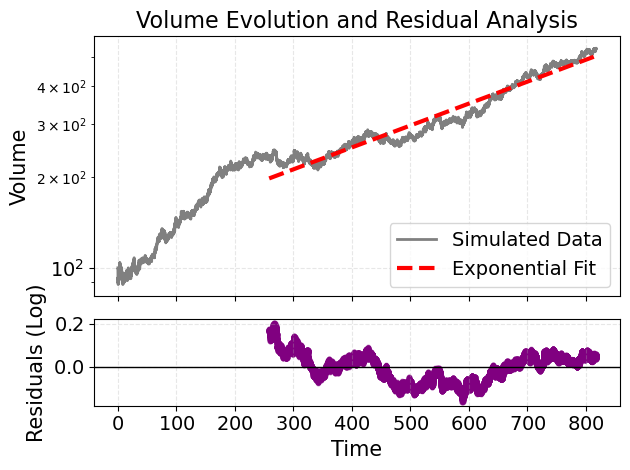

Plot with residuals generated successfully.
k = 0.1
Regression completed. Fitted Scaling Constant A: 93.043
Fitted exponential rate m (alpha): 0.012
Coefficient of Determination (R^2): 0.9963


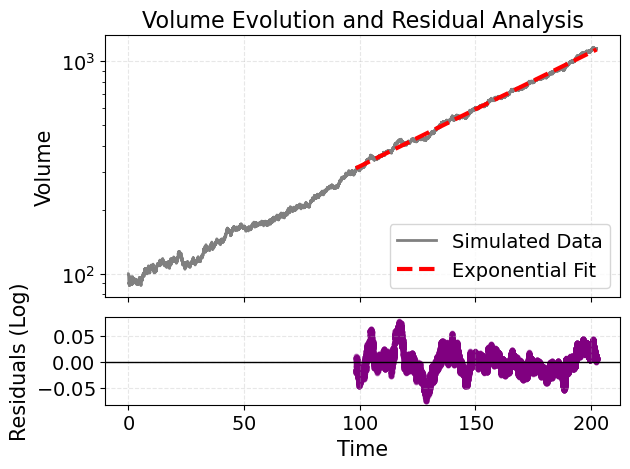

Plot with residuals generated successfully.
k = 0.31622776601683794
Regression completed. Fitted Scaling Constant A: 118.118
Fitted exponential rate m (alpha): 0.067
Coefficient of Determination (R^2): 0.9995


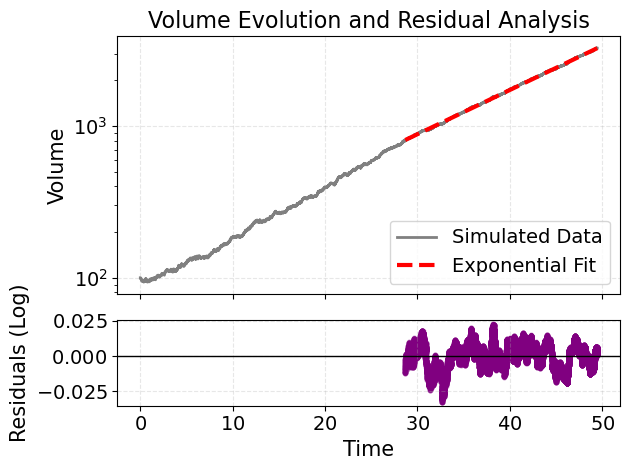

Plot with residuals generated successfully.
k = 1.0
Regression completed. Fitted Scaling Constant A: 69.624
Fitted exponential rate m (alpha): 0.180
Coefficient of Determination (R^2): 0.9999


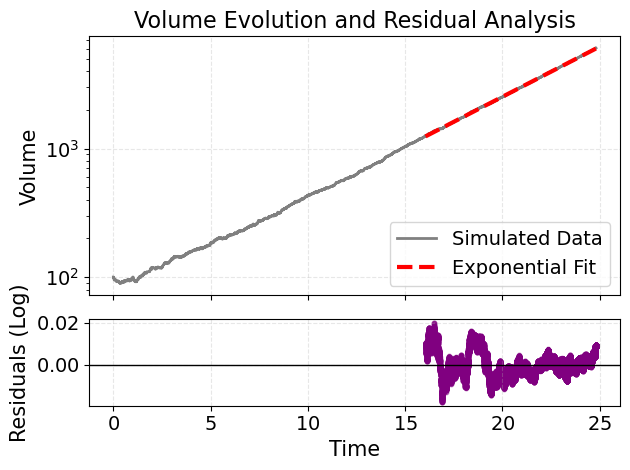

Plot with residuals generated successfully.
k = 3.1622776601683795
Regression completed. Fitted Scaling Constant A: 94.667
Fitted exponential rate m (alpha): 0.320
Coefficient of Determination (R^2): 0.9999


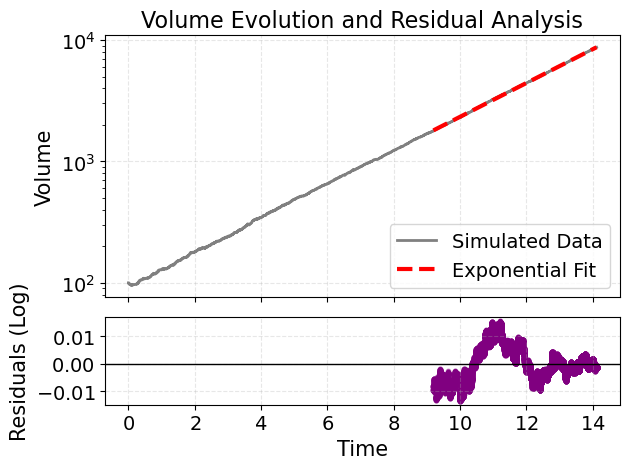

Plot with residuals generated successfully.
k = 10.0
Regression completed. Fitted Scaling Constant A: 107.572
Fitted exponential rate m (alpha): 0.432
Coefficient of Determination (R^2): 0.9998


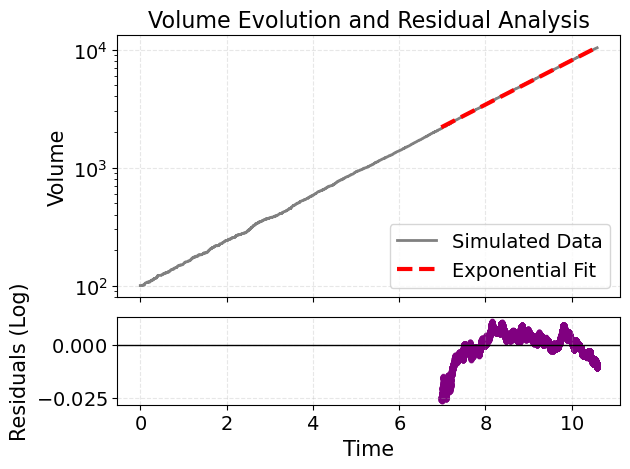

Plot with residuals generated successfully.
k = 31.622776601683793
Regression completed. Fitted Scaling Constant A: 105.119
Fitted exponential rate m (alpha): 0.497
Coefficient of Determination (R^2): 1.0000


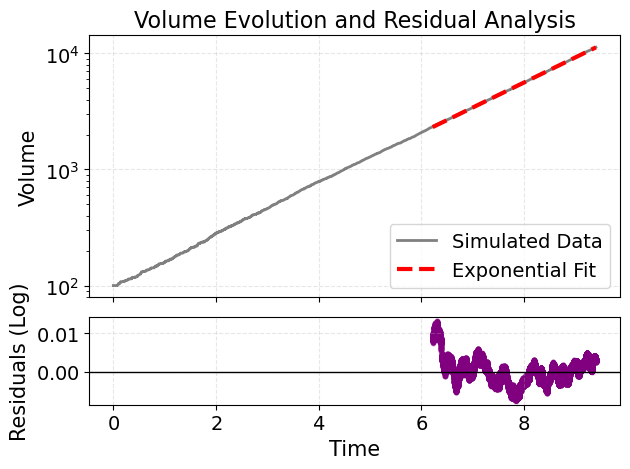

Plot with residuals generated successfully.
k = 100.0
Regression completed. Fitted Scaling Constant A: 95.813
Fitted exponential rate m (alpha): 0.516
Coefficient of Determination (R^2): 0.9998


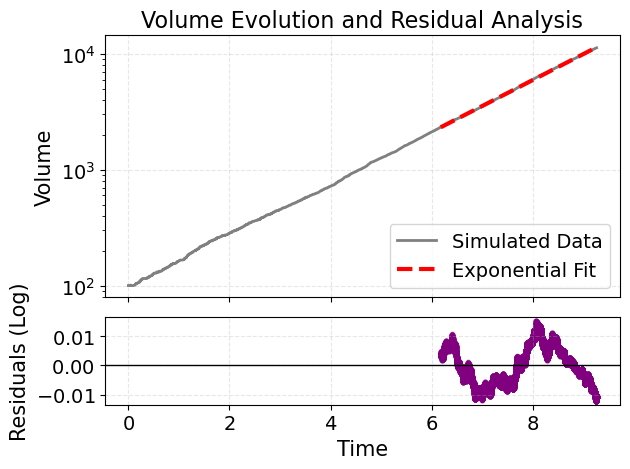

Plot with residuals generated successfully.
k = 316.22776601683796
Regression completed. Fitted Scaling Constant A: 102.875
Fitted exponential rate m (alpha): 0.529
Coefficient of Determination (R^2): 0.9999


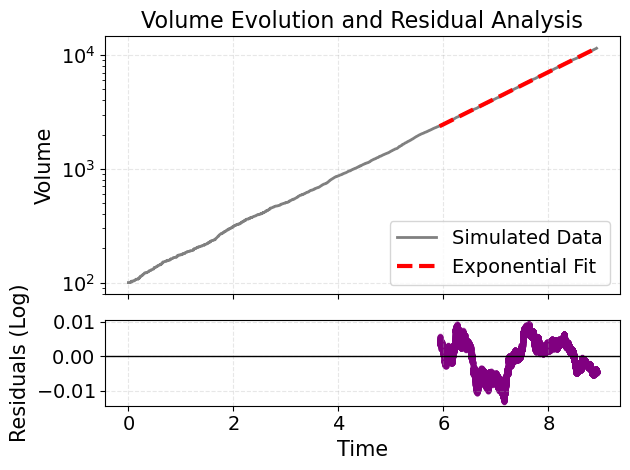

Plot with residuals generated successfully.
k = 1000.0
Regression completed. Fitted Scaling Constant A: 83.071
Fitted exponential rate m (alpha): 0.531
Coefficient of Determination (R^2): 1.0000


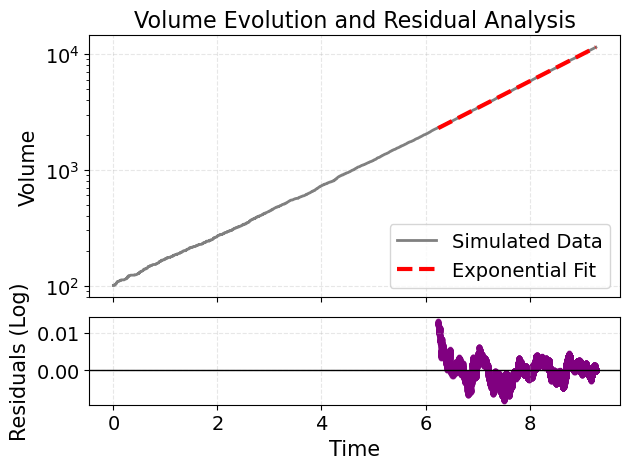

Plot with residuals generated successfully.
k = 3162.2776601683795
Regression completed. Fitted Scaling Constant A: 97.545
Fitted exponential rate m (alpha): 0.532
Coefficient of Determination (R^2): 0.9999


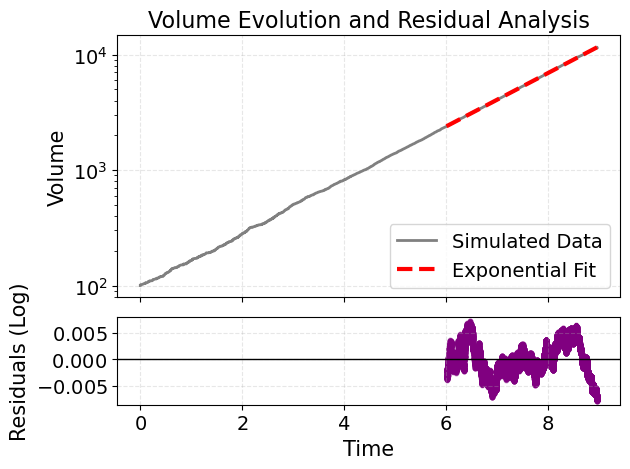

Plot with residuals generated successfully.
k = 10000.0
Regression completed. Fitted Scaling Constant A: 103.184
Fitted exponential rate m (alpha): 0.531
Coefficient of Determination (R^2): 0.9999


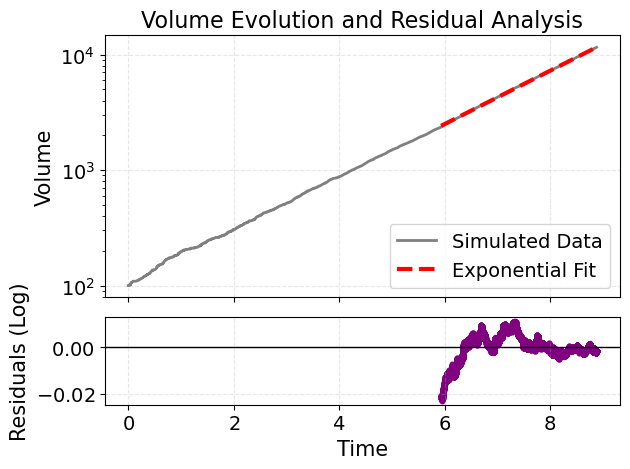

Plot with residuals generated successfully.
k = 31622.776601683792
Regression completed. Fitted Scaling Constant A: 98.160
Fitted exponential rate m (alpha): 0.537
Coefficient of Determination (R^2): 0.9999


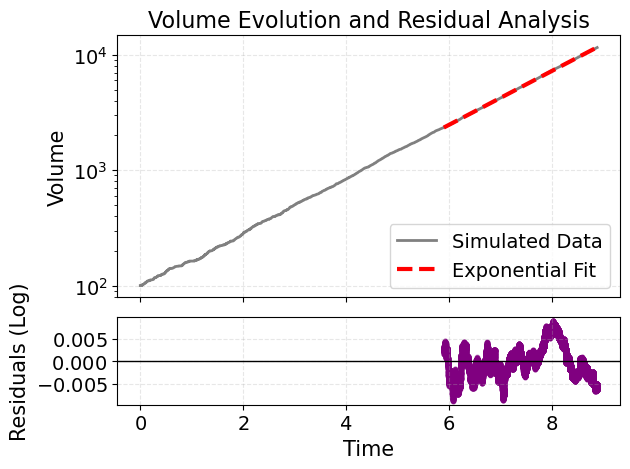

Plot with residuals generated successfully.
k = 100000.0
Regression completed. Fitted Scaling Constant A: 100.675
Fitted exponential rate m (alpha): 0.538
Coefficient of Determination (R^2): 1.0000


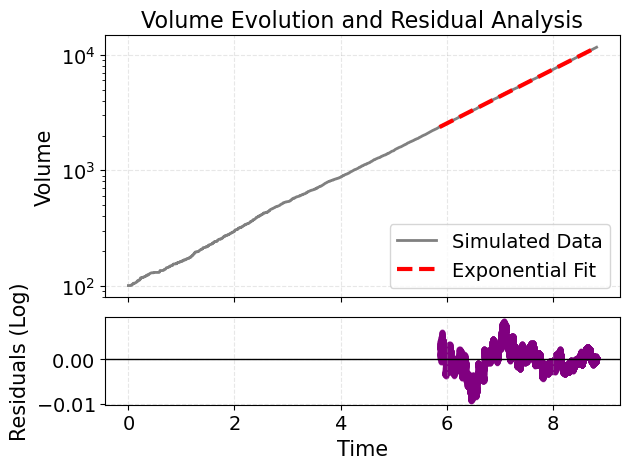

Plot with residuals generated successfully.
k = 316227.7660168379
Regression completed. Fitted Scaling Constant A: 100.060
Fitted exponential rate m (alpha): 0.522
Coefficient of Determination (R^2): 0.9999


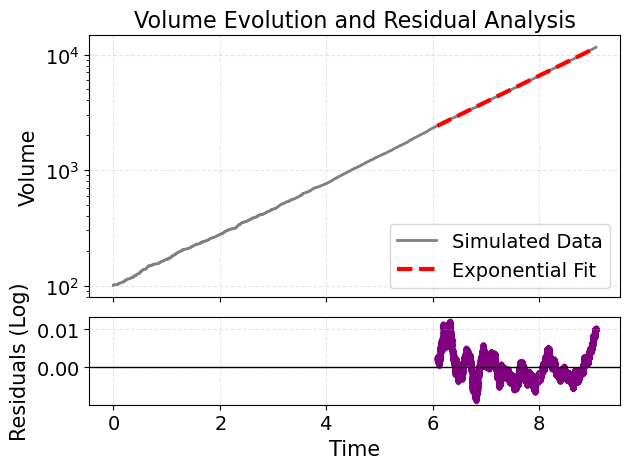

Plot with residuals generated successfully.
k = 1000000.0
Regression completed. Fitted Scaling Constant A: 107.189
Fitted exponential rate m (alpha): 0.526
Coefficient of Determination (R^2): 0.9999


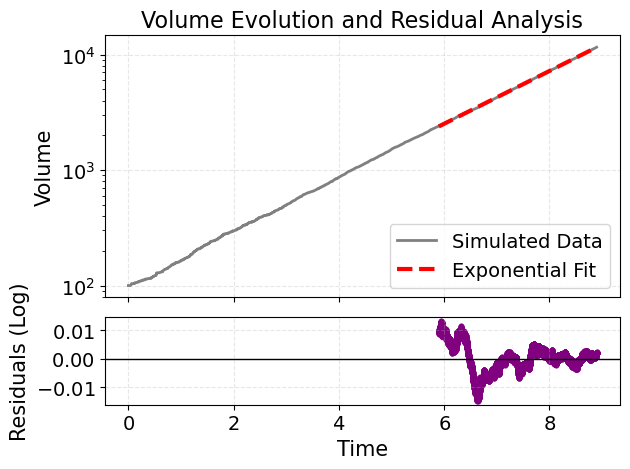

Plot with residuals generated successfully.
k = 3162277.6601683795
Regression completed. Fitted Scaling Constant A: 93.690
Fitted exponential rate m (alpha): 0.540
Coefficient of Determination (R^2): 0.9999


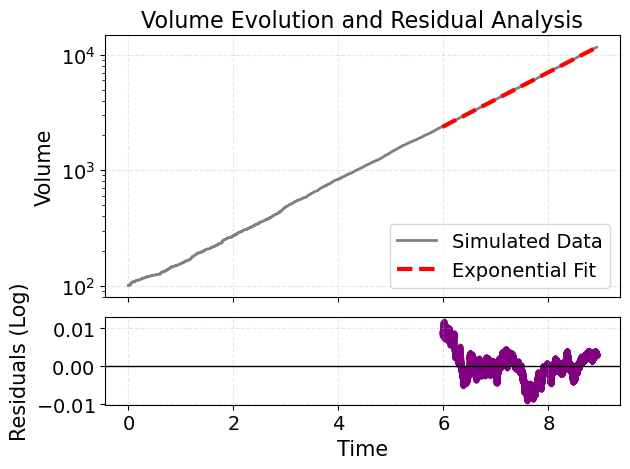

Plot with residuals generated successfully.
k = 10000000.0
Regression completed. Fitted Scaling Constant A: 91.234
Fitted exponential rate m (alpha): 0.534
Coefficient of Determination (R^2): 0.9998


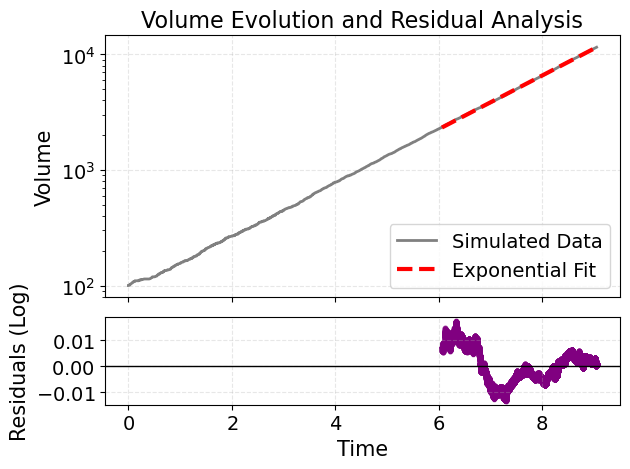

Plot with residuals generated successfully.


In [37]:
for cond in results.keys():
    print(fr"k = {cond}")
    a, t, v = results[cond][0]
    plot_vol(t, v)

In [39]:
import pandas as pd

def export_to_r(result, filename="sim_data.csv"):
    # Unpack assuming the structure: (_, times, volumes)
    _, times, volumes = result
    
    # We export log_volume because that's what you're actually modeling
    df = pd.DataFrame({
        'time': times,
        'volume': volumes,
        'log_volume': np.log(volumes)
    })
    
    df.to_csv(filename, index=False)
    print(f"Data saved for R analysis: {filename}")

# Usage:
export_to_r(results[1e-05][0], "protocell_sim_prueba2.csv")

Data saved for R analysis: protocell_sim_prueba2.csv


# figura molona barrido

Performing simulation for          [ab] = 328.0893322451151,          [cd] = 8.532099679711093,          [acd] = 357.32412030925514,              [cab] = 306.0544477659187
Simulation run completed


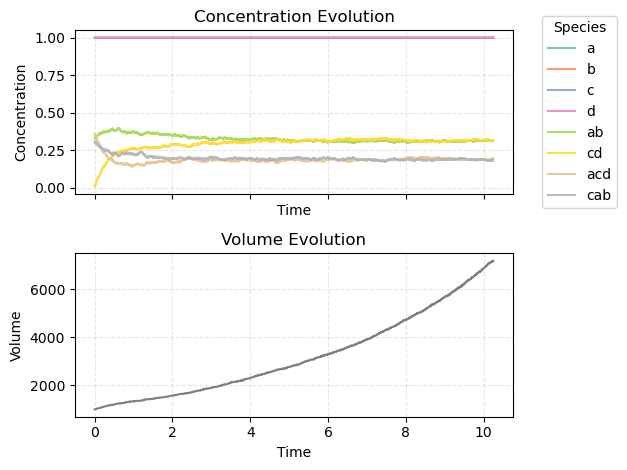

Performing simulation for          [ab] = 349.4760073044385,          [cd] = 415.04385872804613,          [acd] = 116.68012007474016,              [cab] = 118.80001389277527
Simulation run completed


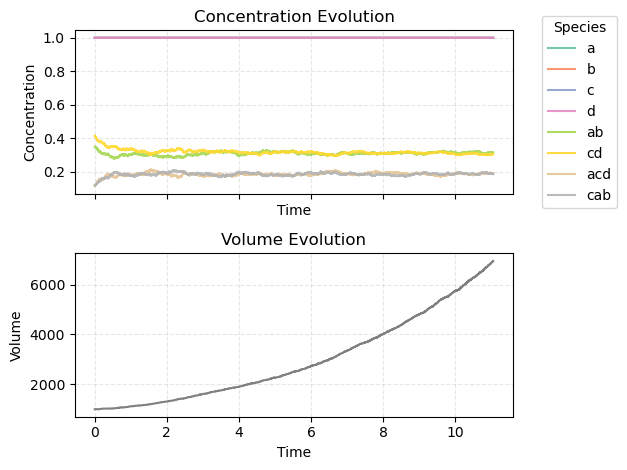

Performing simulation for          [ab] = 214.45769724746117,          [cd] = 207.73384820954587,          [acd] = 96.85854016495102,              [cab] = 480.94991437804185
Simulation run completed


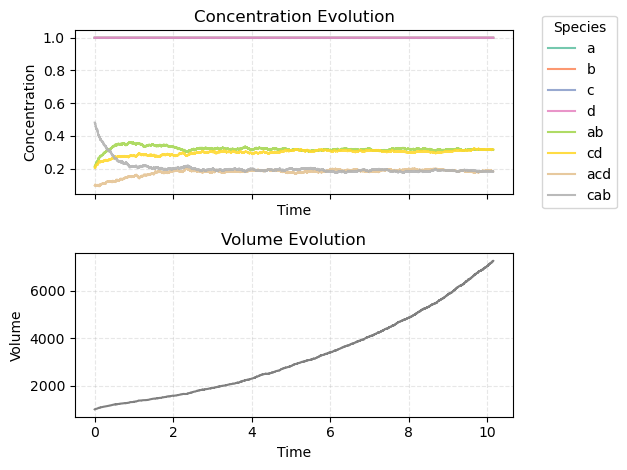

Performing simulation for          [ab] = 167.8366232069985,          [cd] = 283.96448264035376,          [acd] = 205.50675921667116,              [cab] = 342.6921349359766
Simulation run completed


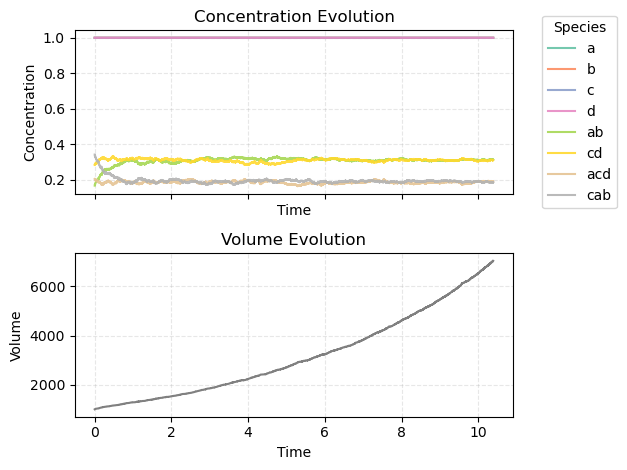

Performing simulation for          [ab] = 341.5474094213408,          [cd] = 334.89162038311963,          [acd] = 90.56630707177432,              [cab] = 232.99466312376518
Simulation run completed


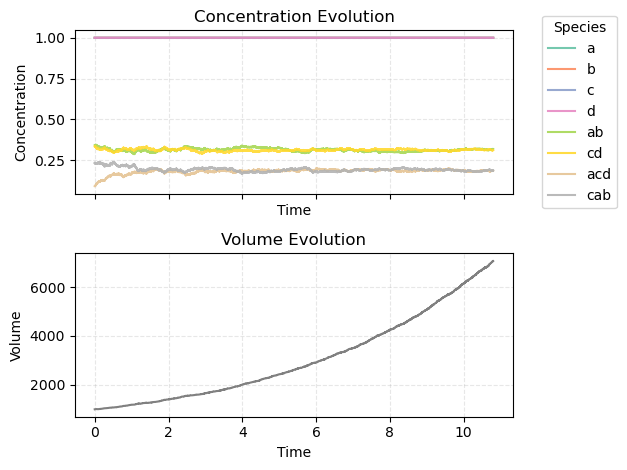

Performing simulation for          [ab] = 356.3736468786459,          [cd] = 243.6825077251294,          [acd] = 77.79102904471775,              [cab] = 322.15281635150706
Simulation run completed


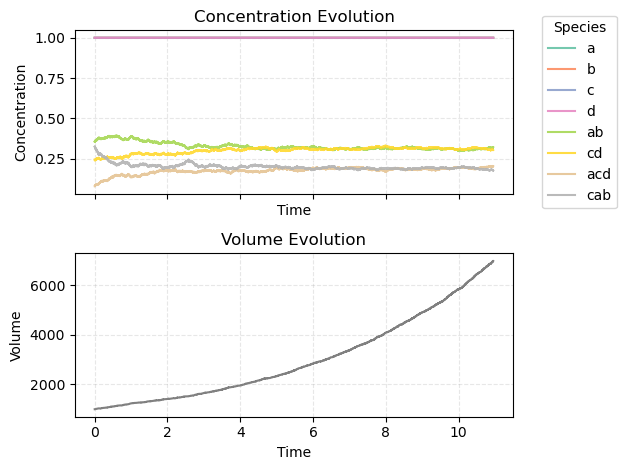

Performing simulation for          [ab] = 277.50564761322335,          [cd] = 207.2350965352669,          [acd] = 12.084899374263218,              [cab] = 503.17435647724653
Simulation run completed


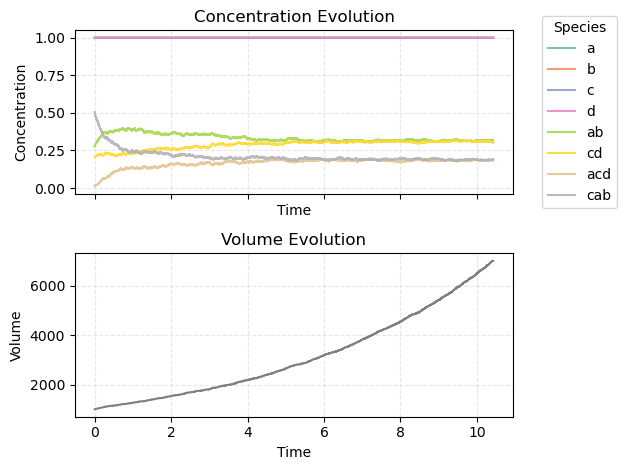

Performing simulation for          [ab] = 0.5608373709496635,          [cd] = 0.6624299734925688,          [acd] = 812.6362316444514,              [cab] = 186.14050101110624
Simulation run completed


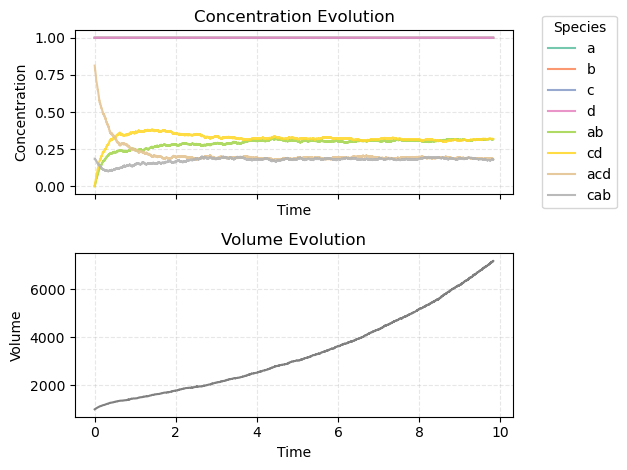

Performing simulation for          [ab] = 30.060707526540384,          [cd] = 324.5116222256082,          [acd] = 260.2868839837149,              [cab] = 385.1407862641364
Simulation run completed


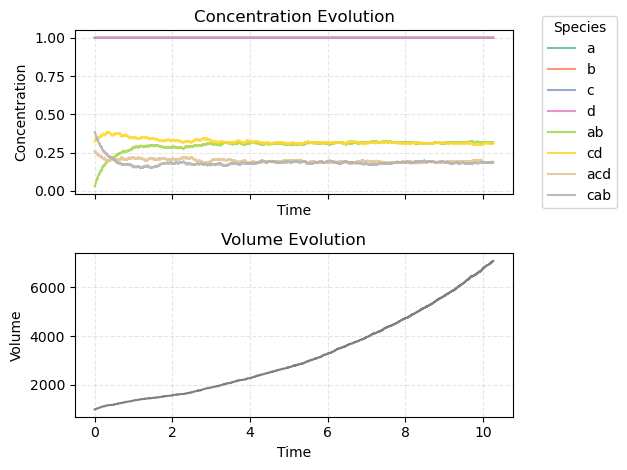

Performing simulation for          [ab] = 303.8492197216934,          [cd] = 159.8068442724261,          [acd] = 262.21534909374947,              [cab] = 274.12858691213097
Simulation run completed


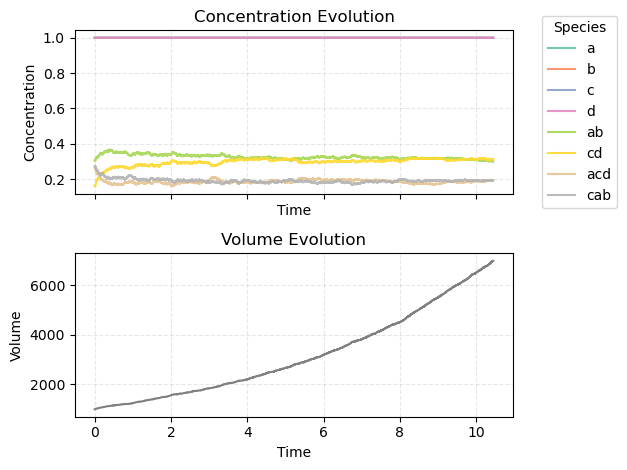

Performing simulation for          [ab] = 87.35376828109791,          [cd] = 363.0164494242573,          [acd] = 385.73364825540443,              [cab] = 163.8961340392404
Simulation run completed


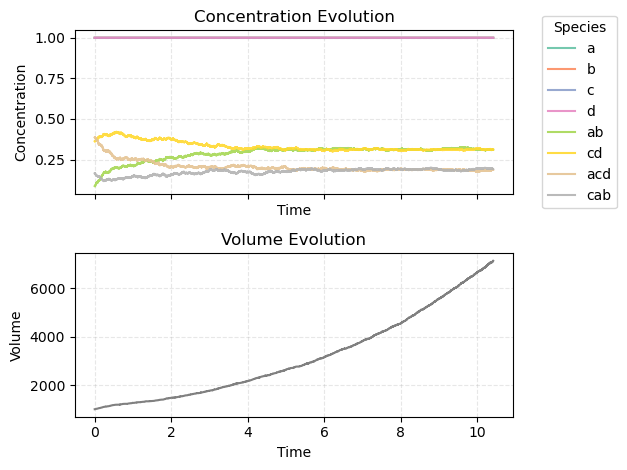

In [34]:
from random import random
import pickle
output_file = "different_initial_conditions.pkl"

n_iterations = 2e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [0]*4 # initial molecules number
concentration = 1
final_concentrations = []
initial_conditions = []
input_file = "../examples/reactions_autocat.txt"
species= obtain_species(read_file(input_file))
total_abundance = concentration * V


for i in range(11,22):
    for j in range(4, len(species)):
        initial_food[j] = random()
        
    total_0 = sum(initial_food[4:])
    for j in range(4, len(species)):
        initial_food[j] = (initial_food[j]/total_0)*concentration*V
    
    print(f"Performing simulation for\
          [ab] = {initial_food[4]},\
          [cd] = {initial_food[5]},\
          [acd] = {initial_food[6]},\
              [cab] = {initial_food[7]}")
    
    abundances, times, volumes = chemistry(method, n_iterations, input_file,
                            initial_food, k, V)
    
    concentrations = (abundances.T / volumes).T
    
    initial_conditions.append(initial_food[4:])
    final_concentrations.append(np.mean(concentrations[-500:,4:], axis= 0))
    
    try: 
        with open(output_file, "ab") as file:
            pickle.dump({i:[initial_conditions,final_concentrations]}, file)
            file.flush()
    except Exception as e:
        print(f"An error has occured: {e}")

    finally: 
        print("Simulation run completed")

    plot(abundances, times, volumes, species)
    
initial_conditions = np.array(initial_conditions)
final_concentrations = np.array(final_concentrations)      

  

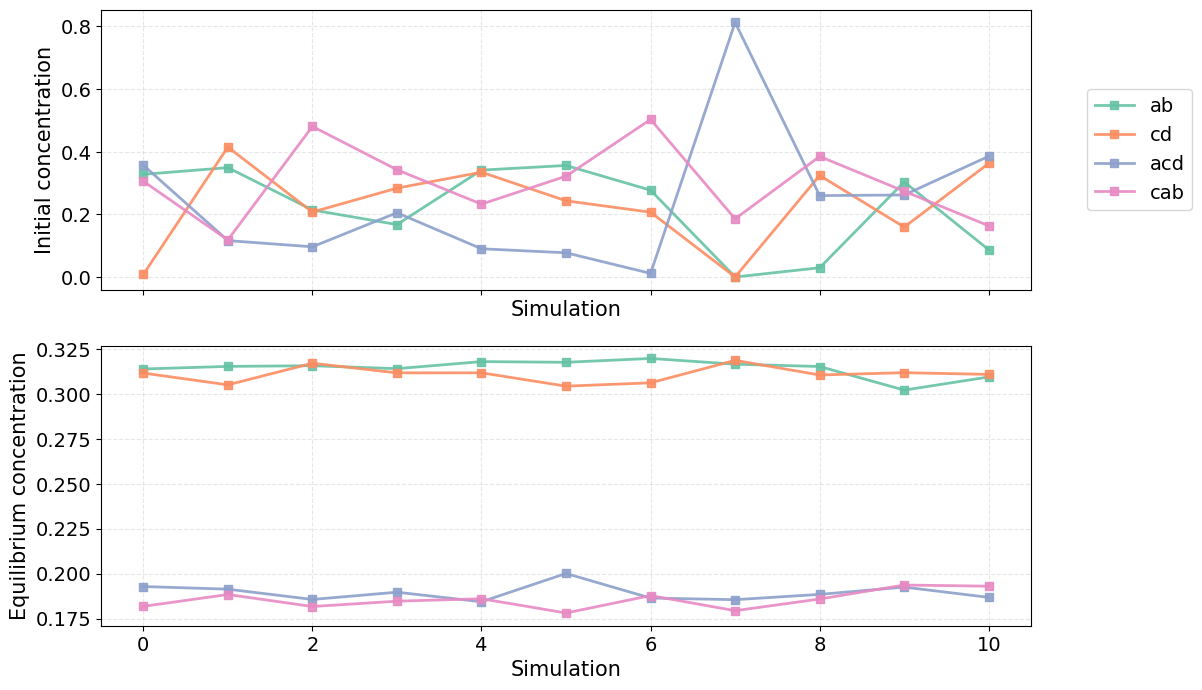

In [35]:
plot_barrido(initial_conditions/V, final_concentrations, species[4:])


# barrido doble

## funciones

In [34]:
def load_alpha_grid(filename):
        # Load the pre-calculated grid
    with open(filename, "rb") as f:
        alpha_grid = pickle.load(f)
    return alpha_grid


def plot_precalculated_alpha(alpha_grid, k_values, k_in, k_out, min_log=-5, max_log=7):
    """
    Plots the heatmap using the already computed alpha_grid.
    """

    # 1. Identify indices for range filtering
    log_k = np.log10(k_values)
    mask = (log_k >= min_log) & (log_k <= max_log)
    
    # 2. Slice the pre-calculated grid
    filtered_grid = alpha_grid[mask][:, mask]
    filtered_k = log_k[mask]
    
    if filtered_grid.size == 0:
        print("Error: No data found in the specified log range.")
        return
    
    # 3. Plotting
    plt.figure()
    extent = [filtered_k[0], filtered_k[-1], filtered_k[0], filtered_k[-1]]
    
    # Set manual maximum for better visualization as you requested
    vmax_limit = min(np.max(filtered_grid), 0.06) 
    if vmax_limit <= 0: vmax_limit = 1 

    im = plt.imshow(filtered_grid, origin='lower', extent=extent,
                    aspect='auto', cmap='magma', vmin=0, vmax=vmax_limit)

    cbar = plt.colorbar(im, extend='max')
    cbar.ax.tick_params(labelsize=tick_fs)
    cbar.set_label(r'Growth Rate ($\alpha$)', rotation=270, labelpad=20, fontsize=label_fs)
    
    plt.xlabel(fr'$\log(k_{{{k_in}}})$', fontsize=label_fs)
    plt.ylabel(fr'$\log(k_{{{k_out}}})$', fontsize=label_fs)
    plt.tick_params(axis='both', labelsize=tick_fs)
    
    plt.tight_layout()
    plt.show()

In [35]:
def plot_r2_hazard_map(r2_grid, k_values, k_in, k_out, min_log=-5, max_log=7):
    """
    Plots the pre-calculated R^2 grid as a heatmap.
    """
    # 1. Axis preparation and slicing
    log_k = np.log10(k_values)
    mask = (log_k >= min_log) & (log_k <= max_log)
    
    filtered_grid = r2_grid[mask][:, mask]
    filtered_k = log_k[mask]
    
    if filtered_grid.size == 0:
        print("No data in range.")
        return
        
    # 2. Plotting
    plt.figure()
    extent = [filtered_k[0], filtered_k[-1], filtered_k[0], filtered_k[-1]]
    
    # Using 'inferno' as in your original code; 'viridis' is also great for 0-1 scales
    im = plt.imshow(filtered_grid, origin='lower', extent=extent, 
                    aspect='auto', cmap='inferno', vmin=0, vmax=1)
    
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=tick_fs)
    cbar.set_label(r'$R^2$', rotation=270, labelpad=20, fontsize=label_fs)
    
    plt.xlabel(fr'$\log(k_{{{k_in}}})$', fontsize=label_fs)
    plt.ylabel(fr'$\log(k_{{{k_out}}})$', fontsize=label_fs)
    plt.tick_params(axis='both', labelsize=tick_fs)
    
    plt.tight_layout()
    plt.show()

In [36]:
def get_data_for_specific_k(raw_data, k_values, target_k_in, target_k_out):
    # 1. Find the indices in your k_change array
    # We use np.isclose to avoid floating point precision issues
    try:
        idx_k1 = np.where(np.isclose(k_values, target_k_out))[0][0]
        idx_k2 = np.where(np.isclose(k_values, target_k_in))[0][0]
    except IndexError:
        print(f"Values k1={target_k_out} or k2={target_k_in} not found in k_values.")
        return None

    # 2. Calculate the flat index 'i' used in the pickle
    n = len(k_values)
    target_idx = (idx_k1 * n) + idx_k2
    
    # 3. Search for this index in your loaded data
    if target_idx in raw_data:
        return raw_data[target_idx] # Returns the list of replicates
        
    print(f"Index {target_idx} not found in the provided data.")
    return None

In [37]:
def get_k_values_from_indices(row, col, k_values):
    """
    Translates grid row and column indices into the actual k values.
    
    Parameters:
    row (int): The row index (corresponding to the outer loop/y-axis).
    col (int): The column index (corresponding to the inner loop/x-axis).
    k_values (array): The array of k values used (e.g., k_change).
    
    Returns:
    tuple: (k_value_y, k_value_x)
    """
    if row >= len(k_values) or col >= len(k_values):
        return "Index out of bounds", "Index out of bounds"
    
    k_y = k_values[row] # alto
    k_x = k_values[col] # bajo
    
    return k_y, k_x

In [38]:
import matplotlib.colors as mcolors
def plot_division_hazard_map(td_grid, k_values, k1_idx, k2_idx, n_divisions=1, min_log=-5, max_log=7):
    """
    Plots the pre-calculated division time grid as a heatmap.
    """
    
    # 1. Axis preparation and slicing
    log_k = np.log10(k_values)
    mask = (log_k >= min_log) & (log_k <= max_log)
    
    filtered_grid = td_grid[mask][:, mask]
    filtered_k = log_k[mask]
    
    if np.all(np.isnan(filtered_grid)):
        print("Error: No successful divisions found in this parameter range.")
        return
        
    # 2. Plotting
    plt.figure()
    extent = [filtered_k[0], filtered_k[-1], filtered_k[0], filtered_k[-1]]
    
    # Use LogNorm so colors are distinguishable across different orders of magnitude
    # viridis_r makes FAST times (low values) bright/yellow
    # norm = mcolors.LogNorm(vmin=np.nanmin(filtered_grid), vmax=np.nanmax(filtered_grid))
    vmax_limit = min(np.max(filtered_grid), 10) 
    if vmax_limit <= 0: vmax_limit = 1 
    
    # im = plt.imshow(filtered_grid, origin='lower', extent=extent, 
    #                 aspect='auto', cmap='viridis_r', norm=norm)
    im = plt.imshow(filtered_grid, origin='lower', extent=extent, 
                    aspect='auto', cmap='viridis_r', vmin=0, vmax=vmax_limit)
    
    cbar = plt.colorbar(im, extend= 'max')
    cbar.ax.tick_params(labelsize=tick_fs)
    cbar.set_label(f'Time to reach {n_divisions} division(s)', rotation=270, labelpad=20, fontsize=label_fs)
    
    plt.xlabel(fr'$\log(k_{{{k1_idx + 1}}})$', fontsize=label_fs)
    plt.ylabel(fr'$\log(k_{{{k2_idx + 1}}})$', fontsize=label_fs)
    plt.tick_params(axis='both', labelsize=tick_fs)
    
    plt.tight_layout()
    plt.show()

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_phase_plane(raw_data, k_values, condition_indices, species_idx_AB, species_idx_CD, ky, kx):
    """
    Plots the phase plane (Conc AB vs Conc CD) for specific conditions.
    """
    plt.figure(figsize=(8, 8))
    n = len(k_values)
    
    # Use a colormap to distinguish different conditions
    colors = plt.cm.viridis(np.linspace(0, 1, len(condition_indices)))

    for i, idx in enumerate(condition_indices):
        # Find the data for this index in raw_data
        # Handle the list of dictionaries structure
        idx = int(idx)
            
        # Plot only the first replicate to keep the plot clean
        rep = raw_data[idx]
        abundances = np.array(rep[0]) # Shape [time_points, num_species]
        times = np.array(rep[1])
        volumes = np.array(rep[2])
        
        # Calculate concentrations: [X] = molecules / Volume
        # abundances[:, species_idx_AB] is a vector of counts over time
        conc_AB = abundances[:, species_idx_AB] / volumes
        conc_CD = abundances[:, species_idx_CD] / volumes
        
        k_y, k_x = get_k_values_from_indices(idx//n, idx%n, k_values)
        # Plot the trajectory
        plt.plot(conc_AB, conc_CD, color=colors[i], alpha=0.8, 
                 label=f'$k_{kx}$={k_x}, $k_{ky}$={k_y}')
        
        # Mark the start and end points
        plt.scatter(conc_AB[0], conc_CD[0], color='green', s=20, marker='o') # Start
        plt.scatter(conc_AB[-1], conc_CD[-1], color='red', s=30, marker='x')  # End

    plt.xlabel(f'Concentration of AB', fontsize=14)
    plt.ylabel(f'Concentration of CD', fontsize=14)
    plt.title('Phase Plane: AB vs CD Concentrations', fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example Usage:
# target_indices = [0, 312, 624] # Choose indices from your sweep
# plot_phase_plane(data, k_change, target_indices, species_idx_AB=4, species_idx_CD=6)

In [40]:
def filter_results_fixed_k(results, k_values, fixed_val, fix_axis='row'):
    """
    Filters the sweep results to keep one k constant.
    
    fix_axis='row': keeps the outer loop k constant (Y-axis of heatmap)
    fix_axis='col': keeps the inner loop k constant (X-axis of heatmap)
    """
    n = len(k_values)
    # Find the index of the fixed value in your k_change array
    fixed_idx = np.argmin(np.abs(k_values - fixed_val))
    
    filtered_slice = {}
    
    if fix_axis == 'row':
        # Condition index: idx = fixed_idx * n + col
        for col in range(n):
            idx = fixed_idx * n + col
            if idx in results:
                # We label it with the value that IS changing (k_col)
                filtered_slice[k_values[col]] = results[idx]
                
    elif fix_axis == 'col':
        # Condition index: idx = row * n + fixed_idx
        for row in range(n):
            idx = row * n + fixed_idx
            if idx in results:
                # We label it with the value that IS changing (k_row)
                filtered_slice[k_values[row]] = results[idx]
                
    return filtered_slice

## figuras

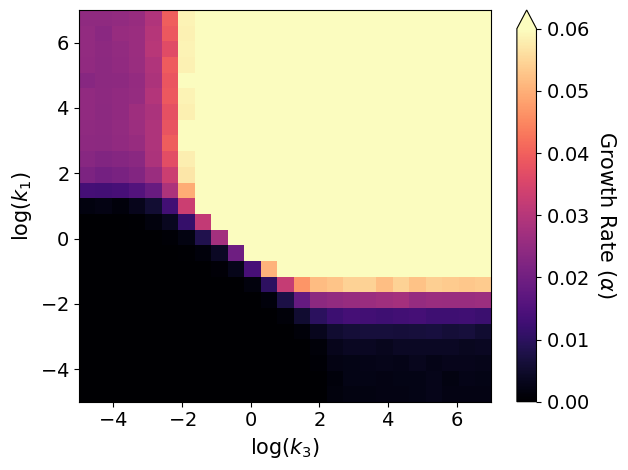

In [41]:
# Run the visualization
k2_vs_k4 = load_alpha_grid("alpha_sweep_k0_k2.pkl")
k_change = np.logspace(-5,7,25)

plot_precalculated_alpha(k2_vs_k4, k_change, k_in=3, k_out=1)

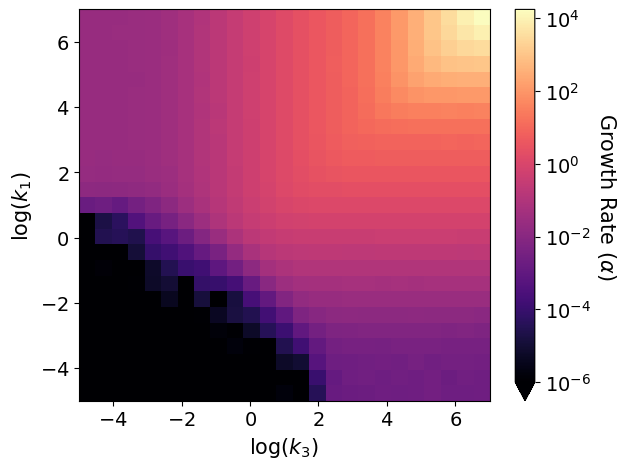

In [45]:
import matplotlib.colors as mcolors

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

def plot_precalculated_alpha_log_full(alpha_grid, k_values, k_in, k_out, min_log=-5, max_log=7):
    """
    Plots the heatmap using a logarithmic color scale with a baseline minimum
    to ensure all pixels are rendered.
    """
    # 1. Identify indices for range filtering
    log_k = np.log10(k_values)
    mask = (log_k >= min_log) & (log_k <= max_log)
    
    # 2. Slice the pre-calculated grid
    filtered_grid = alpha_grid[mask][:, mask]
    filtered_k = log_k[mask]
    
    if filtered_grid.size == 0:
        print("Error: No data found in the specified log range.")
        return

    # 3. Handle NaN and non-positive values
    # We set a baseline floor (e.g., 1e-6) so every pixel is colorable
    baseline_min = 1e-6
    # Replace NaNs with baseline
    filtered_grid = np.nan_to_num(filtered_grid, nan=baseline_min)
    # Clip any values below baseline (including 0 or negative growth)
    filtered_grid = np.maximum(filtered_grid, baseline_min)
    
    # 4. Plotting
    plt.figure()
    extent = [filtered_k[0], filtered_k[-1], filtered_k[0], filtered_k[-1]]
    
    # LogNorm scale from our baseline to the actual maximum found in data
    norm = mcolors.LogNorm(vmin=baseline_min, vmax=np.max(filtered_grid))

    im = plt.imshow(filtered_grid, origin='lower', extent=extent,
                    aspect='auto', cmap='magma', norm=norm)

    # 5. Colorbar and Labels
    # Use 'min' for extend to show that everything below 1e-6 is the same "floor" color
    cbar = plt.colorbar(im, extend='min')
    cbar.ax.tick_params(labelsize=tick_fs)
    cbar.set_label(r'Growth Rate ($\alpha$)', rotation=270, labelpad=20, fontsize=label_fs)
    
    plt.xlabel(fr'$\log(k_{{{k_in}}})$', fontsize=label_fs)
    plt.ylabel(fr'$\log(k_{{{k_out}}})$', fontsize=label_fs)
    plt.tick_params(axis='both', labelsize=tick_fs)
    
    plt.tight_layout()
    plt.show()
    
plot_precalculated_alpha_log_full(k2_vs_k4, k_change, k_in=3, k_out=1)

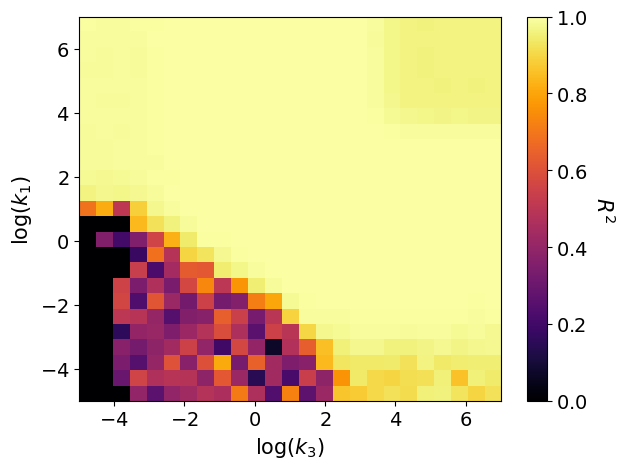

In [146]:
# Run the visualization

r2_grid = load_alpha_grid('r2_sweep_k0_k2.pkl')
plot_r2_hazard_map(r2_grid, k_change, 3,1)

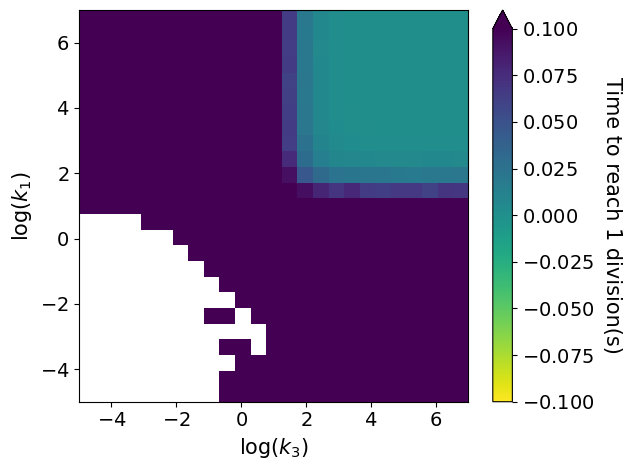

In [147]:
growth = load_alpha_grid('division_sweep_k0_k2.pkl')
plot_division_hazard_map(growth, k_change, 2, 0, n_divisions=1)

In [25]:
# 1. Define your parameters
results = load_streamed_pickle("short_barrido_k0_k2.pkl")
fixed_k1_value = 10**-4
k_change = np.logspace(-5, 7, 25)

# 2. Slice the data (Fixing row means fixing the first k of your sweep)
data_slice = filter_results_fixed_k(results, k_change, fixed_k1_value, fix_axis='row')

# keys_to_delete = [k for k in data_slice if '3' in str(k)]

# for k in keys_to_delete:
#     del data_slice[k]
# 3. Plot using your existing function
# k_i should be the index of the k that is CHANGING (e.g., if k3 is changing, k_i=2)


Successfully loaded 625 simulation results.


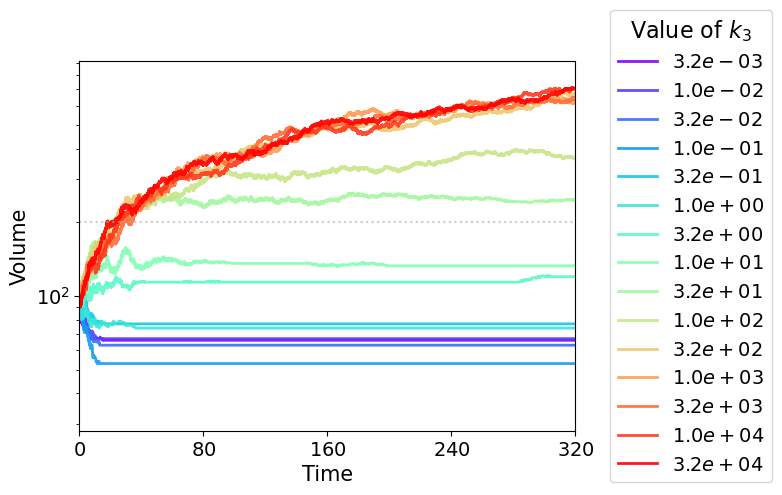

dict_keys([1e-05, 3.1622776601683795e-05, 0.0001, 0.00031622776601683794, 0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0, 3162.2776601683795, 10000.0, 31622.776601683792, 100000.0, 316227.7660168379, 1000000.0, 3162277.6601683795, 10000000.0])

In [87]:
plot_all_volumes(data_slice, k_i=2, lim=[1e-3,1e5], xlim= 320)
data_slice.keys()


## elegir fit

In [ ]:

for cond in results.keys():
    
    a,t,v = results[cond]
    K, alpha_logi, V0 = perform_logistic_fit(t, v)

    exponential_func = get_alpha(v, t, False)
    # 1. Get predicted volumes for both models
    v_pred_exp = [exponential_func(ti) for ti in t]
    v_pred_logi = K / (1 + ((K - V0) / V0) * np.exp(-alpha_logi * t))

    # 2. Calculate RMSE for both
    _, rmse_exp = calculate_fit_metrics(v, v_pred_exp)
    _, rmse_logi = calculate_fit_metrics(v, v_pred_logi)

    if rmse_logi < rmse_exp:
        log += 1
    else:
        exp +=1
        exponentials += [cond]
    
print(f"Cases where and exponential fit is better = {exp}")
print(f"Cases where and exponential fit is not better = {log}")


KeyboardInterrupt: 

In [180]:
regime_grid= generate_regime_grid(results, k_change)

In [159]:
try:
    with open("regime_grid_k0_k2.pkl",'ab') as file:
        pickle.dump(regime_grid, file)
except Exception as e:
    print(f"Error: {e}")
        

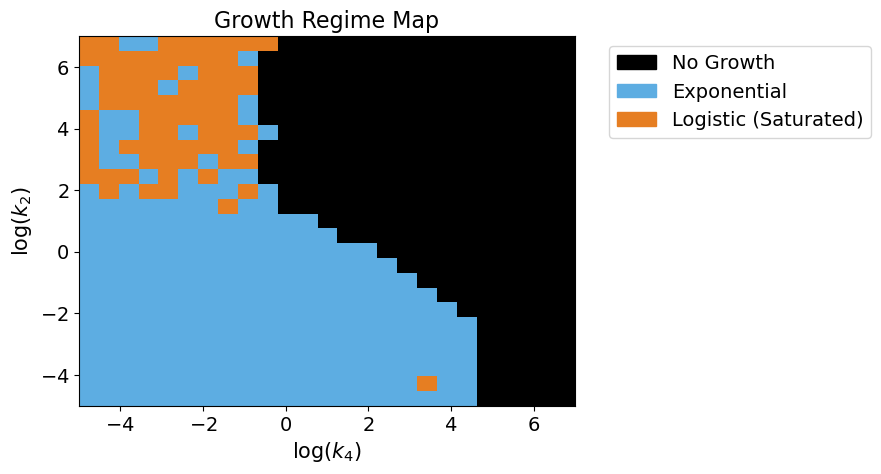

In [181]:
plot_regime_map(regime_grid, k_change, 3, 1)

## phase plane

In [1]:
k_change = np.logspace(-5,7,25)
data = load_streamed_pickle("short_barrido_k0_k2.pkl")
plot_phase_plane(data, k_change, range(1,624,20), 4, 5, 3, 1)
data.keys()

NameError: name 'np' is not defined

# division

In [21]:
a,t,v = chemistry("Division", 1e5, f, [100]*4 + [10]*2 + [0]*2,
                  [1e6,1,1e-4,1] + [1]*4, 100)

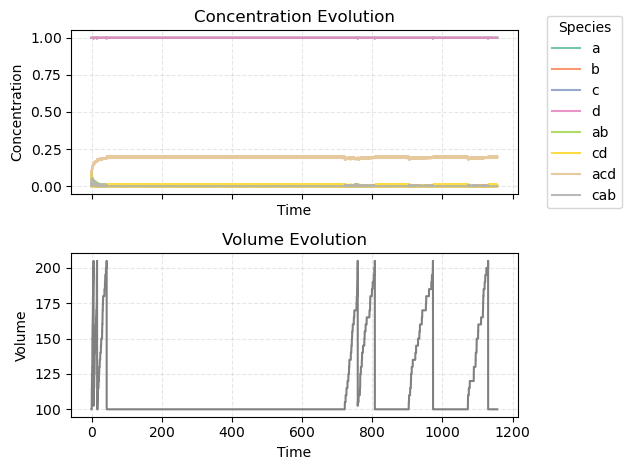

In [23]:
plot(a, t, v, species, )

Criterion for stop was # of iterations


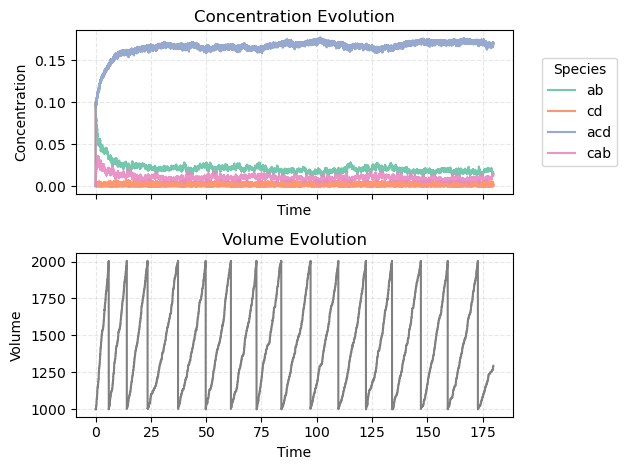

In [60]:
a,t,v = chemistry("Division", 1e5, f, [1000]*4 + [100]*2 + [0]*2,
                  [1e2,1,1e-2,1] + [1]*4, 1000, threshold= 0)
plot(a[:,4:], t, v, species[4:],)

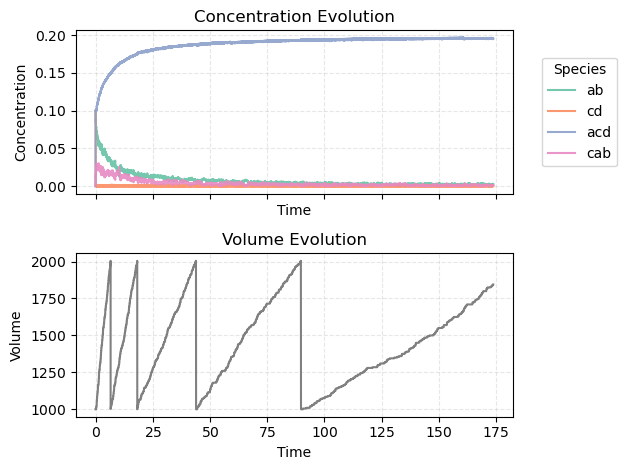

In [55]:
plot(a[:,4:], t, v, species[4:],)

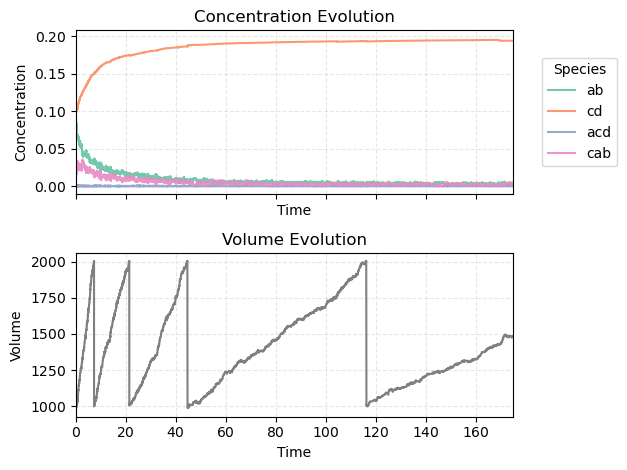

In [ ]:
a,t,v = chemistry("Division", 1e5, f, [1000]*4 + [100]*2 + [0]*2,
                  [1e-4,1,1e4,1] + [1]*4, 1000)
plot(a[:,4:], t, v, species[4:], xlim= 175)

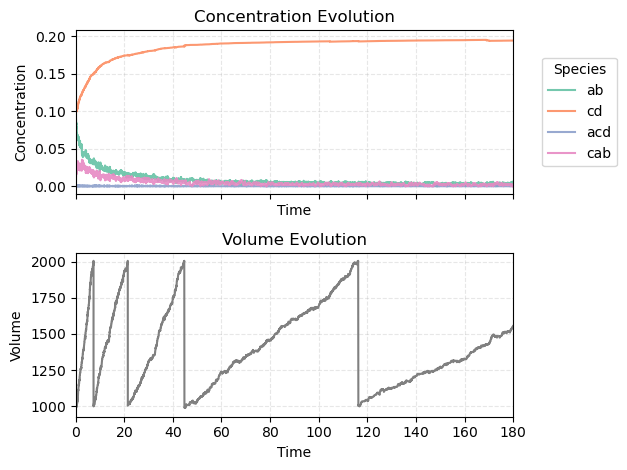

In [59]:
plot(a[:,4:], t, v, species[4:], xlim= 180)

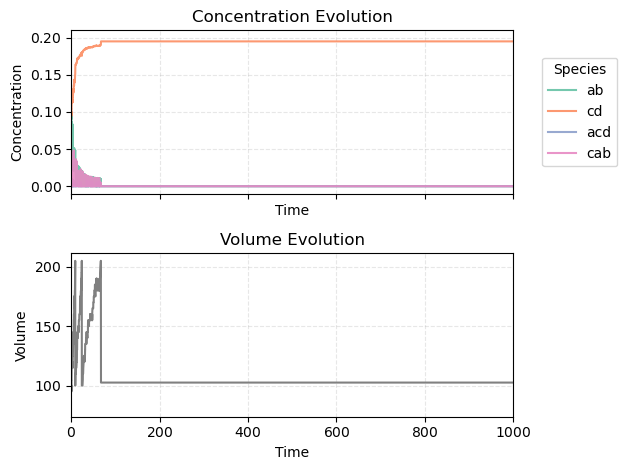

In [32]:
a,t,v = chemistry("Division", 1e5, f, [100]*4 + [10]*2 + [0]*2,
                  [1e-7,1,1e4,1] + [1]*4, 100)
plot(a[:,4:], t, v, species[4:], xlim = 1000)

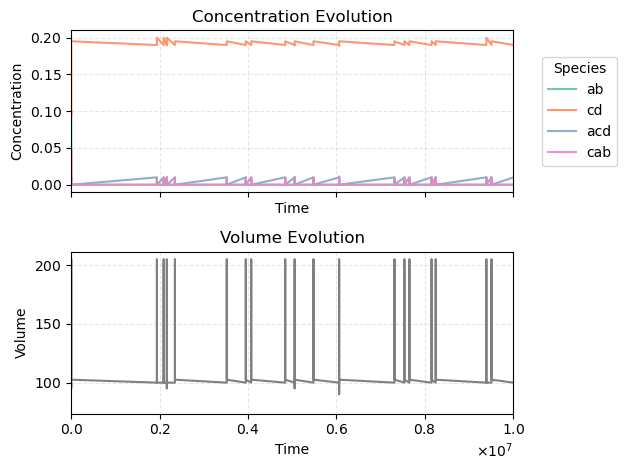

In [41]:
plot(a[:,4:], t, v, species[4:], xlim= 1e7)

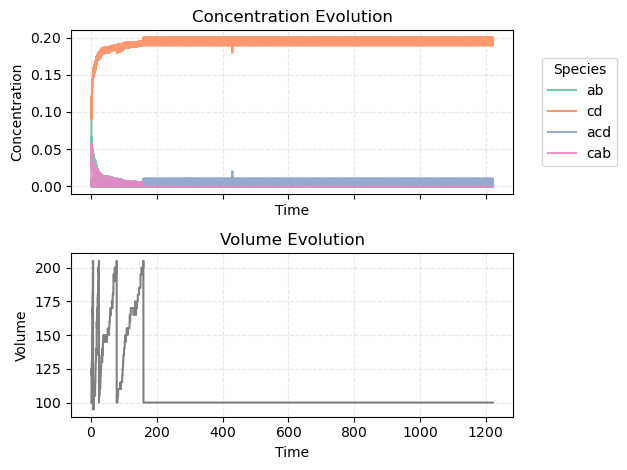

In [61]:
a,t,v = chemistry("Division", 1e5, f, [100]*4 + [10]*2 + [0]*2,
                  [1,1e6,1,1e-4] + [1]*4, 100)
plot(a[:,4:], t, v, species[4:])

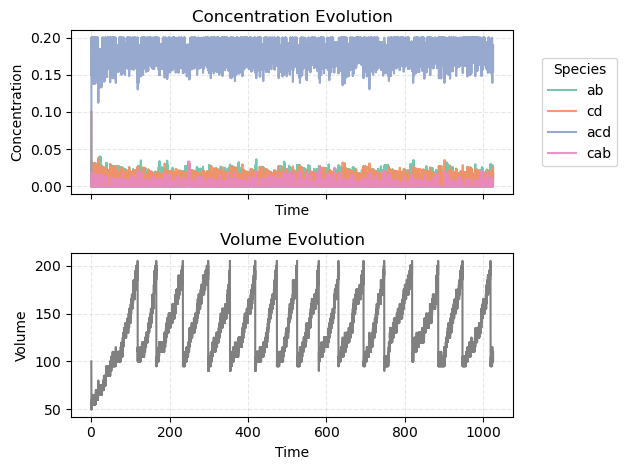

In [63]:
a,t,v = chemistry("Division", 1e5, f, [100]*4 + [10]*2 + [0]*2,
                  [1,1e-4,1,1e4] + [1]*4, 100)
plot(a[:,4:], t, v, species[4:])